# Loading data and setting variables

This script plots the hole-checking (uncertainty) analysis of mice in the static entrance vs. random entrance conditions

In [1]:
import os
import copy
import numpy
import modules.io as io
import modules.plot_func as pltt
import modules.traj_analysis as tran
import modules.helper_func_class as misc
import modules.process_mouse_trials_lib as plib
import matplotlib.pyplot as plt
import scipy.stats
import warnings

warnings.filterwarnings('ignore')
#import matplotlib.image as mpimg


"""

THE SUFFIXES IN THE VARIABLE NAMES

*** rt suffix -> relative target experiments
                 this means STATIC entrance,
                 since the target is always
                 positioned in the same spot
                 relative to the entrance
                 the mouse takes

*** ft suffix -> fixed target experiments
                 this means RANDOM entrance,
                 since the target is in a
                 different spot in every trial,
                 relative to the entrance the mouse
                 takes

*** 2t suffix -> two target experiments
                 mice are trained in two locations, consecutively

"""

mouse_traj_dir_rt     = r'./experiments/relative_target/mouse_*'
mouse_traj_dir_ft     = r'./experiments/fixed_target/mouse_*'
mouse_traj_dir_2t     = r'./experiments/two_target_no_cues/mouse_*'
selfint_file_variable = 'selfint_st_rt'

output_dir = 'figs/paper/uncertainty_random_vs_static'
try:
    os.makedirs(output_dir)
except FileExistsError:
    pass

colors = pltt.get_gradient(5,'blue2')

color_lightblue   = numpy.array((65, 102, 216, 255))/255 #pltt.get_gradient(5,'blue2')[2] #numpy.array((65, 102, 216, 255))/255
color_darkblue    = pltt.get_gradient(2,'blue')[1] #numpy.array((224, 53, 53, 255))/255
color_lightred    = pltt.get_gradient(2,'red')[0] #numpy.array((65, 102, 216, 255))/255 #pltt.get_gradient(5,'blue2')[2] #numpy.array((65, 102, 216, 255))/255
color_darkred     = pltt.get_gradient(2,'red')[1] #numpy.array((224, 53, 53, 255))/255
color_lightyellow = numpy.append(pltt.get_gradient(10,'yellow')[2],1.0)
color_darkyellow  = numpy.append(pltt.get_gradient(2,'yellow')[::-1][0],1.0)

color_rt_h1 = color_lightblue
color_rt_h2 = color_darkblue
color_ft_h1 = color_lightred #numpy.array((65, 102, 216, 255))/255 #pltt.get_gradient(5,'blue2')[2] #numpy.array((65, 102, 216, 255))/255
color_ft_h2 = color_darkred #numpy.array((224, 53, 53, 255))/255

SMALL_FONTSIZE  = 12
MEDIUM_FONTSIZE = 14
LARGE_FONTSIZE  = 16
plt.rc('font',        size=SMALL_FONTSIZE )  # controls default text sizes
plt.rc('axes',   titlesize=SMALL_FONTSIZE )  # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_FONTSIZE) # fontsize of the x and y labels
plt.rc('xtick',  labelsize=SMALL_FONTSIZE ) # fontsize of the tick labels
plt.rc('ytick',  labelsize=SMALL_FONTSIZE ) # fontsize of the tick labels
plt.rc('legend',  fontsize=SMALL_FONTSIZE ) # legend fontsize
plt.rc('figure', titlesize=LARGE_FONTSIZE ) # fontsize of the figure title


FIGSIZE_1PANEL = numpy.array((4,3),dtype=float)
AX_POS_1PANEL  = numpy.array( [ 0.125, 0.125, 0.9, 0.88 ] ) # [xmin,ymin,width,heigh]
AX_POS_2PANELS = numpy.array([   AX_POS_1PANEL/2.0,
                               [ 1.5*AX_POS_1PANEL[0]+AX_POS_1PANEL[2]/2,AX_POS_1PANEL[1]/2,AX_POS_1PANEL[2]/2-0.5*AX_POS_1PANEL[0],AX_POS_1PANEL[3]/2 ] ])


# linear regression aux function
linreg_lin_func = lambda x,lr: lr.intercept + lr.slope * x
linreg_pl_func  = lambda x,lr: numpy.exp(lr.intercept + numpy.log(x)*lr.slope)
linreg_exp_func = lambda x,lr: numpy.exp(lr.intercept + x*lr.slope)

# t-test aux function
p_significant = 0.05
q_FDR         = 0.05 # FDR-level for thresholding p_values correcting for false-discovery rate in multiple comparisons
check_significance = lambda ttest_res: ttest_res.pvalue < p_significant


# loads experiment MAT files from file path according to the parameters

time_delay_after_food  = 3.0 # sec

# all_trials[k][m] -> mouse m in trial k
all_trials_rt,trial_labels_rt       = io.load_trial_file(mouse_traj_dir_rt,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True)
all_trials_rt                       = tran.remove_path_after_food(all_trials_rt,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
all_trials_rt_h1,trial_labels_rt_h1 = io.load_trial_file(mouse_traj_dir_rt,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=True ,align_to_top=True,group_by='trial',return_group_by_keys=True,t0_frac=0.0,dt_frac=0.5,time_delay_after_food=time_delay_after_food)
all_trials_rt_h2,trial_labels_rt_h2 = io.load_trial_file(mouse_traj_dir_rt,load_only_training_sessions_relative_target=True,skip_15_relative_target=False,use_extra_trials_relative_target=True ,sort_by_trial=True,fix_nan=True,remove_after_food=True ,align_to_top=True,group_by='trial',return_group_by_keys=True,t0_frac=0.5,dt_frac=1.0,time_delay_after_food=time_delay_after_food)

# all_trials[k][m] -> mouse m in trial k
all_trials_ft,trial_labels_ft       = io.load_trial_file(mouse_traj_dir_ft,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=len(all_trials_rt))
all_trials_ft                       = tran.remove_path_after_food(all_trials_ft,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
all_trials_ft_h1,trial_labels_ft_h1 = io.load_trial_file(mouse_traj_dir_ft,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=True ,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=len(all_trials_rt),t0_frac=0.0,dt_frac=0.5,time_delay_after_food=time_delay_after_food)
all_trials_ft_h2,trial_labels_ft_h2 = io.load_trial_file(mouse_traj_dir_ft,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=True ,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=len(all_trials_rt),t0_frac=0.5,dt_frac=1.0,time_delay_after_food=time_delay_after_food)


n_trials_h1 = 14 # 1st half
n_trials_h2 = 14 # 2nd half
n_trials = numpy.min((n_trials_h2,n_trials_h1))


save_output_figures = True

# STATIC TARGET

### n_holes NUMBER OF CHECKED HOLES PER UNIT DISTANCE TRAVELED

NUMBER OF CHECKED HOLES per distance travelled

     First half (1 vs. 14)
          first trial: m+-SD = 0.039245664 +- 0.017143614  cm^{-1}
           last trial: m+-SD = 0.028530067 +- 0.015382275  cm^{-1}
     Second half (1 vs. 14)
          first trial: m+-SD = 0.03988045 +- 0.015359125  cm^{-1}
           last trial: m+-SD = 0.087900891 +- 0.10428721  cm^{-1}

 *** T-Test between first and last trials

     1st half (1 vs. 14)   :: T = 1.230879     p = 0.23887903
     2nd half (1 vs. 14)   :: T = -1.2052702     p = 0.26569387
 



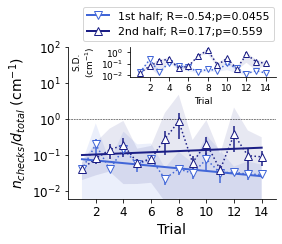

In [9]:
"""
###############
###############
###############
###############
############### n_holes NUMBER OF CHECKED HOLES PER UNIT DISTANCE TRAVELED
###############
###############
###############
###############
"""

# calculating the slowing down instants and positions in the 3 cm radius of holes
hole_horizon = 3.0 # in cm (units is mouse.unit_r)
#slo_st_h1 = [ misc.structtype(struct_fields=['tind','t','r','v_th'],field_values=tran.find_slowing_down_close_to_hole(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='mouse')) for all_mice in all_trials_h1 ]
#slo_st_h2 = [ misc.structtype(struct_fields=['tind','t','r','v_th'],field_values=tran.find_slowing_down_close_to_hole(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='mouse')) for all_mice in all_trials_h2 ]
n_holes_h1 = [ tran.calc_number_checked_holes_per_dist(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1) for all_mice in all_trials_rt_h1 ]
n_holes_h2 = [ tran.calc_number_checked_holes_per_dist(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1) for all_mice in all_trials_rt_h2 ]

#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
n_holes_mmean_sd_err_h1 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(n_holes_h1),axis=1)).T # trial[0] -> mean of each mice
n_holes_mmean_sd_err_h2 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(n_holes_h2),axis=1)).T # trial[0] -> mean of each mice
# col0 -> mean
# col1 -> sd
# col2 -> se
# col3 -> min
# col4 -> max
# row -> trial (mean over mice)

# calculating the error of the standard deviation
# to be able to plot the standard deviation as a function of trial
n_holes_mstd_sd_minmax_h1 = numpy.array([numpy.fromiter(misc.flatten_list(misc.bootstrap_func(nn,numpy.std,return_bs_confint_se=True)),dtype=float) for nn in n_holes_h1])
n_holes_mstd_sd_minmax_h2 = numpy.array([numpy.fromiter(misc.flatten_list(misc.bootstrap_func(nn,numpy.std,return_bs_confint_se=True)),dtype=float) for nn in n_holes_h2])
# col0 -> stddev
# col1 -> min stddev 0.95 confint
# col2 -> max stddev 0.95 confint
# col3 -> StdErr of stddev 0.95 confint

#######
####### calculating the z-scores
#######

# using the random entrance (i.e. fixed target ft) as control trials
n_holes_Z_h1,n_holes_Z_h2  = misc.zscore_to_control(  misc.asarray_nanfill(n_holes_h1)[:n_trials,:], misc.asarray_nanfill(n_holes_h2)[:n_trials,:]   , axis=1)
n_holes_mmean_sd_err_Z_h1 = numpy.array(misc.mean_std_err_minmax(n_holes_Z_h1,axis=1)).T
n_holes_mmean_sd_err_Z_h2 = numpy.array(misc.mean_std_err_minmax(n_holes_Z_h2,axis=1)).T


#######
####### calculating distributions
#######

n_bins = 25
P_n_holes_h1 = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in n_holes_h1 ]
P_n_holes_h2 = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in n_holes_h2 ]

#######
####### calculating correlation with trial n
#######

linearize_func = numpy.log  # lambda x:x
linreg_func    = linreg_exp_func # linreg_lin_func

n_holes_linreg_trial_h1   = misc.linregress(numpy.arange(n_trials_h1), linearize_func(n_holes_mmean_sd_err_h1[:n_trials_h1,0]), alternative='two-sided')
n_holes_linreg_trial_h2   = misc.linregress(numpy.arange(n_trials_h2), linearize_func(n_holes_mmean_sd_err_h2[:n_trials_h2,0]), alternative='two-sided')
n_holes_Z_linreg_trial_h1 = misc.linregress(numpy.arange(n_trials)   , linearize_func(n_holes_mmean_sd_err_Z_h1[:,0]         ), alternative='two-sided')
n_holes_Z_linreg_trial_h2 = misc.linregress(numpy.arange(n_trials)   , linearize_func(n_holes_mmean_sd_err_Z_h2[:,0]         ), alternative='two-sided')


#######
####### t-test
#######

# comparing each trial of rt vs. ft
n_holes_ttest_trials  = scipy.stats.ttest_ind(n_holes_Z_h1,n_holes_Z_h2,axis=1,equal_var=False,nan_policy='omit',alternative='two-sided')
k_significant_trials = misc.check_p_values(n_holes_ttest_trials,p_significant,q_FDR) # index of significant trials

# comparing first with last trial
n_holes_ttest_first_last_h1 = scipy.stats.ttest_ind(n_holes_h1[0],n_holes_h1[n_trials_h1-1],equal_var=False,nan_policy='omit',alternative='two-sided')
n_holes_ttest_first_last_h2 = scipy.stats.ttest_ind(n_holes_h2[0],n_holes_h2[n_trials_h2-1],equal_var=False,nan_policy='omit',alternative='two-sided')

ttest_result  = 'NUMBER OF CHECKED HOLES per distance travelled\n\n'
ttest_result += f'     First half (1 vs. {n_trials_h1})\n'
ttest_result += f'          first trial: m+-SD = {n_holes_mmean_sd_err_h1[            0,0]:.8g} +- {n_holes_mmean_sd_err_h1[            0,1]:.8g}' + '  cm^{-1}\n'
ttest_result += f'           last trial: m+-SD = {n_holes_mmean_sd_err_h1[n_trials_h1-1,0]:.8g} +- {n_holes_mmean_sd_err_h1[n_trials_h1-1,1]:.8g}' + '  cm^{-1}\n'
ttest_result += f'     Second half (1 vs. {n_trials_h2})\n'
ttest_result += f'          first trial: m+-SD = {n_holes_mmean_sd_err_h2[            0,0]:.8g} +- {n_holes_mmean_sd_err_h2[            0,1]:.8g}' + '  cm^{-1}\n'
ttest_result += f'           last trial: m+-SD = {n_holes_mmean_sd_err_h2[n_trials_h2-1,0]:.8g} +- {n_holes_mmean_sd_err_h2[n_trials_h2-1,1]:.8g}' + '  cm^{-1}\n'
ttest_result += '\n'
ttest_result += ' *** T-Test between first and last trials' + '\n\n'
ttest_result += f'     1st half (1 vs. {n_trials_h1})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(n_holes_ttest_first_last_h1.statistic,n_holes_ttest_first_last_h1.pvalue,'(*)' if check_significance(n_holes_ttest_first_last_h1) else '   ') + '\n'
ttest_result += f'     2nd half (1 vs. {n_trials_h2})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(n_holes_ttest_first_last_h2.statistic,n_holes_ttest_first_last_h2.pvalue,'(*)' if check_significance(n_holes_ttest_first_last_h2) else '   ') + '\n'
ttest_result += ' ' + '\n'
print(ttest_result)

#######
####### calculating correlation with trial n
#######
#fh = plt.figure(figsize=(4,3))
#ax = plt.gca()
fh,axh = plt.subplots(nrows=1,ncols=2,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)

ax=axh[0]
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials_h1)+1,n_holes_mmean_sd_err_h1[:n_trials_h1,0],[n_holes_mmean_sd_err_h1[:n_trials_h1,-2],n_holes_mmean_sd_err_h1[:n_trials_h1,-1]],fmt=':',color=color_rt_h1,ax=ax,markersize=4,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials_h2)+1,n_holes_mmean_sd_err_h2[:n_trials_h2,0],[n_holes_mmean_sd_err_h2[:n_trials_h2,-2],n_holes_mmean_sd_err_h2[:n_trials_h2,-1]],fmt=':',color=color_rt_h2,ax=ax,markersize=3,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials_h1)+1,n_holes_mmean_sd_err_h1[:n_trials_h1,0],n_holes_mmean_sd_err_h1[:n_trials_h1,2],fmt='v',color=color_rt_h1,markersize=8,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials_h2)+1,n_holes_mmean_sd_err_h2[:n_trials_h2,0],n_holes_mmean_sd_err_h2[:n_trials_h2,2],fmt='^',color=color_rt_h2,markersize=8,markerfacecolor='w')
ax.plot(numpy.arange(n_trials_h1)+1,linreg_func(numpy.arange(n_trials_h1)+1,n_holes_linreg_trial_h1),'-',color=color_rt_h1,linewidth=2)
ax.plot(numpy.arange(n_trials_h2)+1,linreg_func(numpy.arange(n_trials_h2)+1,n_holes_linreg_trial_h2),'-',color=color_rt_h2,linewidth=2,label='2nd half; R={0:.2g};p={1:.3g}'.format(n_holes_linreg_trial_h2.rvalue,n_holes_linreg_trial_h2.pvalue))
line_leg_h1 = plt.Line2D([numpy.nan],[numpy.nan],linewidth=2,color=color_rt_h1,markersize=8,marker='v',markerfacecolor='w',label='1st half; R={0:.2g};p={1:.3g}'.format(n_holes_linreg_trial_h1.rvalue,n_holes_linreg_trial_h1.pvalue))
line_leg_h2 = plt.Line2D([numpy.nan],[numpy.nan],linewidth=2,color=color_rt_h2,markersize=8,marker='^',markerfacecolor='w',label='2nd half; R={0:.2g};p={1:.3g}'.format(n_holes_linreg_trial_h2.rvalue,n_holes_linreg_trial_h2.pvalue))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_h2,n_trials_h1))+1)[2::2])
ax.set_xlim(0,numpy.max((n_trials_h2,n_trials_h1))+1)
ax.set_ylim((6e-3,100))
ax.legend(handles=[line_leg_h1,line_leg_h2],loc='lower right', bbox_to_anchor=(1.02, 1),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('$n_{checks}/d_{total}$ (cm$^{-1}$)')
ax.tick_params(axis='both',which='minor',length=0)


data_rt_h1  = n_holes_mmean_sd_err_h1
data_rt_h2  = n_holes_mmean_sd_err_h2
ttest_rt_h1 = n_holes_ttest_first_last_h1
ttest_rt_h2 = n_holes_ttest_first_last_h2
data = list(data_rt_h1[:n_trials,0]) + list(data_rt_h2[:n_trials,0])
if check_significance(ttest_rt_h1):
    pltt._annotate_boxplot(ax, 0, n_trials-1, data, data_min=numpy.min(data)-numpy.min(data_rt_h1[:n_trials,2]),
                            dy=1, TXT=None, color=color_rt_h1, is_log_scale=False, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=True, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))
if check_significance(ttest_rt_h2):
    pltt._annotate_boxplot(ax, n_trials, 2*n_trials-1, data, data_max=numpy.max(data)+0.5*numpy.max(data_rt_h2[:n_trials,2]),
                            dy=1, TXT=None, color=color_rt_h2, is_log_scale=False, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=False, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))


ax=axh[1]
p0 = axh[0].get_position()
frac_w = 0.7
frac_h = 0.8
ax.set_position([ p0.x0+(1-frac_w)*p0.width,p0.y0+frac_h*p0.height,p0.width*frac_w,p0.height*(1-frac_h) ])
pltt.plot_errorfill(numpy.arange(n_trials)+1,n_holes_mmean_sd_err_h1[:n_trials,1],[n_holes_mstd_sd_minmax_h1[:n_trials,1],n_holes_mstd_sd_minmax_h1[:n_trials,2]],fmt=':',color=color_rt_h1,ax=ax,markersize=4,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials)+1,n_holes_mmean_sd_err_h2[:n_trials,1],[n_holes_mstd_sd_minmax_h2[:n_trials,1],n_holes_mstd_sd_minmax_h2[:n_trials,2]],fmt=':',color=color_rt_h2,ax=ax,markersize=3,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1,n_holes_mmean_sd_err_h1[:n_trials,1],n_holes_mstd_sd_minmax_h1[:n_trials,-1],fmt='v',label='1st half',color=color_rt_h1,markersize=6,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials)+1,n_holes_mmean_sd_err_h2[:n_trials,1],n_holes_mstd_sd_minmax_h2[:n_trials,-1],fmt='^',label='2nd half',color=color_rt_h2,markersize=6,markerfacecolor='w')
#ax.plot(numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,n_holes_Z_linreg_trial_h1),'-',color=color_h1,linewidth=2,  label='1st half; R={0:.2g};p={1:.3g}'.format(n_holes_Z_linreg_trial_h1.rvalue,n_holes_Z_linreg_trial_h1.pvalue))
#ax.plot(numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,n_holes_Z_linreg_trial_h2),'-',color=color_h2,  linewidth=2,label='2nd half; R={0:.2g};p={1:.3g}'.format(n_holes_Z_linreg_trial_h2.rvalue,n_holes_Z_linreg_trial_h2.pvalue))
ax.set_xticks(numpy.arange(n_trials+1)[2::2])
ax.set_xlim(0,n_trials+1)
#ax.legend(loc='lower right', bbox_to_anchor=(1.02, 1), prop=dict(size=9))
ax.set_xlabel('Trial',           fontsize=9)
ax.set_ylabel('S.D.\n(cm$^{-1}$)',fontsize=9)
ax.set_yscale('log')
ax.tick_params(axis='both',which='major',labelsize=9)
ax.tick_params(axis='both',which='minor',length=0)

pltt.set_box_axis(axh,False)

if save_output_figures:
    plt.savefig(  f'{output_dir}/stat_half_trials_n_holes_per_dist.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    numpy.savetxt(f'{output_dir}/stat_half_trials_n_holes_per_dist_ttest.txt',numpy.array([[]]),header=ttest_result)

plt.show()

### d_holes AVERAGE DIST CHECKED HOLES TO TARGET

AVG CHECKED HOLE DISTANCE TO TARGET

 *** Trial values

     First half (1 vs. 14)
          first trial: m+-SD = 50.502329 +- 19.848211 cm
           last trial: m+-SD = 48.492591 +- 17.234065 cm
     Second half (1 vs. 14)
          first trial: m+-SD = 48.05593 +- 11.504382 cm
           last trial: m+-SD = 3.1338125 +- 5.7030222 cm

 *** T-Test between first and last trials

     1st half (1 vs. 14)   :: T = 0.20228364     p = 0.8426617
     2nd half (1 vs. 14)(*):: T = 9.2561735     p = 2.6953106e-06
 



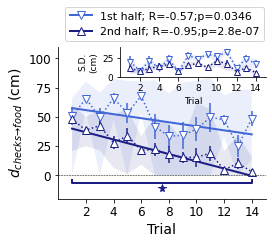

In [6]:
"""
###############
###############
###############
###############
############### d_holes AVERAGE DIST CHECKED HOLES TO TARGET
###############
###############
###############
###############
"""

d_intertarget = plib.get_intertarget_distance_static_entrance()

# calculating the slowing down instants and positions in the 3 cm radius of holes
hole_horizon = 3.0 # in cm (units is mouse.unit_r)

# d == perpendicular distance to food line; first index -> trial, second index -> mouse
d_holes_h1 = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False) for all_mice in all_trials_rt_h1 ]
d_holes_h2 = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False) for all_mice in all_trials_rt_h2 ]


#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
d_holes_hmean_sd_err_h1 = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in d_holes_h1 ] # axis=1 -> average over holes (hmean)
d_holes_mmean_sd_err_h1 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill([ trial[0] for trial in d_holes_hmean_sd_err_h1 ]),axis=1)).T # trial[0] -> mean of each mice

d_holes_hmean_sd_err_h2 = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in d_holes_h2 ] # axis=1 -> average over holes (hmean)
d_holes_mmean_sd_err_h2 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill([ trial[0] for trial in d_holes_hmean_sd_err_h2 ]),axis=1)).T # trial[0] -> mean of each mice
# col0 -> mean
# col1 -> sd
# col2 -> se
# col3 -> min
# col4 -> max
# row -> trial (mean over mice)


# calculating the error of the standard deviation
# to be able to plot the standard deviation as a function of trial
d_holes_mstd_sd_minmax_h1 = numpy.array([numpy.fromiter(misc.flatten_list(misc.bootstrap_func(misc.nanmean(misc.asarray_nanfill(nn),axis=1),numpy.std,return_bs_confint_se=True)),dtype=float) for nn in d_holes_h1])
d_holes_mstd_sd_minmax_h2 = numpy.array([numpy.fromiter(misc.flatten_list(misc.bootstrap_func(misc.nanmean(misc.asarray_nanfill(nn),axis=1),numpy.std,return_bs_confint_se=True)),dtype=float) for nn in d_holes_h2])
# col0 -> stddev
# col1 -> min stddev 0.95 confint
# col2 -> max stddev 0.95 confint
# col3 -> StdErr of stddev 0.95 confint


#######
####### calculating the z-scores
#######

# using the random entrance (i.e. fixed target ft) as control trials
d_holes_Z_h1,d_holes_Z_h2  = misc.zscore_to_control(  misc.asarray_nanfill([ trial[0] for trial in d_holes_hmean_sd_err_h1[:n_trials] ]), misc.asarray_nanfill([ trial[0] for trial in d_holes_hmean_sd_err_h2[:n_trials] ])   , axis=1)
d_holes_mmean_sd_err_Z_h1 = numpy.array(misc.mean_std_err_minmax(d_holes_Z_h1,axis=1)).T
d_holes_mmean_sd_err_Z_h2 = numpy.array(misc.mean_std_err_minmax(d_holes_Z_h2,axis=1)).T

#######
####### calculating correlation with trial n
#######

linearize_func   = lambda x:x #numpy.log
linreg_func      = linreg_lin_func # linreg_exp_func
linearize_func_Z = lambda x:x#numpy.log
linreg_func_Z    = linreg_lin_func

d_holes_linreg_trial_h1   = misc.linregress(numpy.arange(n_trials_h1),     linearize_func(d_holes_mmean_sd_err_h1[:n_trials_h1,0]), alternative='two-sided')
d_holes_linreg_trial_h2   = misc.linregress(numpy.arange(n_trials_h2),     linearize_func(d_holes_mmean_sd_err_h2[:n_trials_h2,0]), alternative='two-sided')
d_holes_Z_linreg_trial_h1 = misc.linregress(numpy.arange(n_trials)   ,   linearize_func_Z(d_holes_mmean_sd_err_Z_h1[:,0]         ), alternative='two-sided')
d_holes_Z_linreg_trial_h2 = misc.linregress(numpy.arange(n_trials)   ,   linearize_func_Z(d_holes_mmean_sd_err_Z_h2[:,0]         ), alternative='two-sided')

#######
####### t-test
#######

# comparing each trial of rt vs. ft
d_holes_ttest_trials  = scipy.stats.ttest_ind(d_holes_Z_h1,d_holes_Z_h2,axis=1,equal_var=False,nan_policy='omit',alternative='two-sided')
k_significant_trials = misc.check_p_values(d_holes_ttest_trials,p_significant,q_FDR) # index of significant trials

# comparing first with last trial
d_holes_ttest_first_last_h1 = scipy.stats.ttest_ind(d_holes_hmean_sd_err_h1[0][0],d_holes_hmean_sd_err_h1[n_trials_h1-1][0],equal_var=False,nan_policy='omit',alternative='two-sided')
d_holes_ttest_first_last_h2 = scipy.stats.ttest_ind(d_holes_hmean_sd_err_h2[0][0],d_holes_hmean_sd_err_h2[n_trials_h2-1][0],equal_var=False,nan_policy='omit',alternative='two-sided')

ttest_result  = 'AVG CHECKED HOLE DISTANCE TO TARGET\n\n'
ttest_result += ' *** Trial values' + '\n\n'
ttest_result += f'     First half (1 vs. {n_trials_h1})\n'
ttest_result += f'          first trial: m+-SD = {d_holes_mmean_sd_err_h1[            0,0]:.8g} +- {d_holes_mmean_sd_err_h1[            0,1]:.8g} cm\n'
ttest_result += f'           last trial: m+-SD = {d_holes_mmean_sd_err_h1[n_trials_h1-1,0]:.8g} +- {d_holes_mmean_sd_err_h1[n_trials_h1-1,1]:.8g} cm\n'
ttest_result += f'     Second half (1 vs. {n_trials_h2})\n'
ttest_result += f'          first trial: m+-SD = {d_holes_mmean_sd_err_h2[            0,0]:.8g} +- {d_holes_mmean_sd_err_h2[            0,1]:.8g} cm\n'
ttest_result += f'           last trial: m+-SD = {d_holes_mmean_sd_err_h2[n_trials_h2-1,0]:.8g} +- {d_holes_mmean_sd_err_h2[n_trials_h2-1,1]:.8g} cm\n'
ttest_result += '\n'
ttest_result += ' *** T-Test between first and last trials' + '\n\n'
ttest_result += f'     1st half (1 vs. {n_trials_h1})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(d_holes_ttest_first_last_h1.statistic,d_holes_ttest_first_last_h1.pvalue,'(*)' if check_significance(d_holes_ttest_first_last_h1) else '   ') + '\n'
ttest_result += f'     2nd half (1 vs. {n_trials_h2})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(d_holes_ttest_first_last_h2.statistic,d_holes_ttest_first_last_h2.pvalue,'(*)' if check_significance(d_holes_ttest_first_last_h2) else '   ') + '\n'
ttest_result += ' ' + '\n'
print(ttest_result)

#######
####### calculating correlation with trial n
#######
#fh = plt.figure(figsize=(4,3))
#ax = plt.gca()
fh,axh = plt.subplots(nrows=1,ncols=2,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)

ax=axh[0]
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials_h1)+1,d_holes_mmean_sd_err_h1[:n_trials_h1,0],[d_holes_mmean_sd_err_h1[:n_trials_h1,-2],d_holes_mmean_sd_err_h1[:n_trials_h1,-1]],fmt=':',color=color_rt_h1,ax=ax,markersize=4,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials_h2)+1,d_holes_mmean_sd_err_h2[:n_trials_h2,0],[d_holes_mmean_sd_err_h2[:n_trials_h2,-2],d_holes_mmean_sd_err_h2[:n_trials_h2,-1]],fmt=':',color=color_rt_h2,ax=ax,markersize=3,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials_h1)+1,d_holes_mmean_sd_err_h1[:n_trials_h1,0],d_holes_mmean_sd_err_h1[:n_trials_h1,2],fmt='v',color=color_rt_h1,markersize=8,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials_h2)+1,d_holes_mmean_sd_err_h2[:n_trials_h2,0],d_holes_mmean_sd_err_h2[:n_trials_h2,2],fmt='^',color=color_rt_h2,markersize=8,markerfacecolor='w')
ax.plot(numpy.arange(n_trials_h1)+1,linreg_func(numpy.arange(n_trials_h1)+1,d_holes_linreg_trial_h1),'-',color=color_rt_h1,linewidth=2)
ax.plot(numpy.arange(n_trials_h2)+1,linreg_func(numpy.arange(n_trials_h2)+1,d_holes_linreg_trial_h2),'-',color=color_rt_h2,linewidth=2)
line_leg_h1 = plt.Line2D([numpy.nan],[numpy.nan],linewidth=2,color=color_rt_h1,markersize=8,marker='v',markerfacecolor='w',label='1st half; R={0:.2g};p={1:.3g}'.format(d_holes_linreg_trial_h1.rvalue,d_holes_linreg_trial_h1.pvalue))
line_leg_h2 = plt.Line2D([numpy.nan],[numpy.nan],linewidth=2,color=color_rt_h2,markersize=8,marker='^',markerfacecolor='w',label='2nd half; R={0:.2g};p={1:.3g}'.format(d_holes_linreg_trial_h2.rvalue,d_holes_linreg_trial_h2.pvalue))
pltt.plot_horizontal_lines(0,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
#ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_h2,n_trials_h1))+1)[2::2])
ax.set_xlim(0,numpy.max((n_trials_h2,n_trials_h1))+1)
ax.set_ylim((-20,110))
ax.legend(handles=[line_leg_h1,line_leg_h2],loc='lower right', bbox_to_anchor=(1.02, 1),fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('$d_{checks\\to food}$ (cm)')



data_rt_h1  = d_holes_mmean_sd_err_h1
data_rt_h2  = d_holes_mmean_sd_err_h2
ttest_rt_h1 = d_holes_ttest_first_last_h1
ttest_rt_h2 = d_holes_ttest_first_last_h2
data = list(data_rt_h1[:n_trials,0]) + list(data_rt_h2[:n_trials,0])
if check_significance(ttest_rt_h1):
    pltt._annotate_boxplot(ax, 0, n_trials-1, data, data_max=numpy.max(data)+0.5*numpy.max(data_rt_h1[:n_trials,2]),
                            dy=1, TXT=None, color=color_rt_h1, is_log_scale=False, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=False, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))
if check_significance(ttest_rt_h2):
    pltt._annotate_boxplot(ax, n_trials, 2*n_trials-1, data, data_min=numpy.min(data)-2*numpy.min(data_rt_h2[:n_trials,2]),
                            dy=2.5, TXT=None, color=color_rt_h2, is_log_scale=False, x1_plot_coord=1, x2_plot_coord=n_trials,
                            use_global_min_max=True, use_min=True, symbol_args=dict(marker='*',markersize=8),
                            line_args=dict(linewidth=2))
    



#fh = plt.figure(figsize=(4,3))
#ax = plt.gca()
ax=axh[1]
p0 = axh[0].get_position()
frac_w = 0.7
frac_h = 0.8
ax.set_position([ p0.x0+(1-frac_w)*p0.width,p0.y0+frac_h*p0.height,p0.width*frac_w,p0.height*(1-frac_h) ])
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_holes_mmean_sd_err_h1[:n_trials,1],[d_holes_mstd_sd_minmax_h1[:n_trials,1],d_holes_mstd_sd_minmax_h1[:n_trials,2]],fmt=':',color=color_rt_h1,ax=ax,markersize=4,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_holes_mmean_sd_err_h2[:n_trials,1],[d_holes_mstd_sd_minmax_h2[:n_trials,1],d_holes_mstd_sd_minmax_h2[:n_trials,2]],fmt=':',color=color_rt_h2,ax=ax,markersize=3,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1,d_holes_mmean_sd_err_h1[:n_trials,1],d_holes_mstd_sd_minmax_h1[:n_trials,-1],fmt='v',label='1st half',color=color_rt_h1,markersize=6,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials)+1,d_holes_mmean_sd_err_h2[:n_trials,1],d_holes_mstd_sd_minmax_h2[:n_trials,-1],fmt='^',label='2nd half',color=color_rt_h2,markersize=6,markerfacecolor='w')
#ax.plot(numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,d_holes_Z_linreg_trial_h1),'-',color=color_h1,linewidth=2,  label='1st half; R={0:.2g};p={1:.3g}'.format(d_holes_Z_linreg_trial_h1.rvalue,d_holes_Z_linreg_trial_h1.pvalue))
#ax.plot(numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,d_holes_Z_linreg_trial_h2),'-',color=color_h2,  linewidth=2,label='2nd half; R={0:.2g};p={1:.3g}'.format(d_holes_Z_linreg_trial_h2.rvalue,d_holes_Z_linreg_trial_h2.pvalue))
ax.set_xticks(numpy.arange(n_trials+1)[2::2])
ax.set_xlim(0,n_trials+1)
ax.set_xlabel('Trial',    fontsize=9)
ax.set_ylabel('S.D.\n(cm)',fontsize=9)
ax.tick_params(axis='both',which='major',labelsize=9)

pltt.set_box_axis(axh,False)

if save_output_figures:
    plt.savefig(  f'{output_dir}/stat_half_trials_holedist.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    numpy.savetxt(f'{output_dir}/stat_half_trials_holedist_ttest.txt',numpy.array([[]]),header=ttest_result)

plt.show()

# RANDOM TARGET

### n_holes number of checked holes

NUMBER OF CHECKED HOLES per distance travelled

 *** T-Test between first and last trials

     1st half (1 vs. 14)   :: T = 0.84835801     p = 0.42145313
     2nd half (1 vs. 14)   :: T = -1.2782147     p = 0.22219206
 



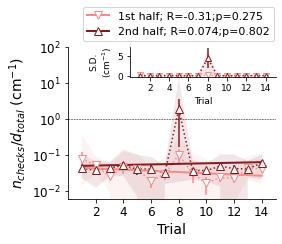

In [4]:
"""
###############
###############
###############
###############
############### n_holes NUMBER OF CHECKED HOLES PER UNIT DISTANCE TRAVELED
###############
###############
###############
###############
"""

# calculating the slowing down instants and positions in the 3 cm radius of holes
hole_horizon = 3.0 # in cm (units is mouse.unit_r)
#slo_st_h1 = [ misc.structtype(struct_fields=['tind','t','r','v_th'],field_values=tran.find_slowing_down_close_to_hole(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='mouse')) for all_mice in all_trials_h1 ]
#slo_st_h2 = [ misc.structtype(struct_fields=['tind','t','r','v_th'],field_values=tran.find_slowing_down_close_to_hole(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='mouse')) for all_mice in all_trials_h2 ]
n_holes_h1 = [ tran.calc_number_checked_holes_per_dist(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1) for all_mice in all_trials_ft_h1 ]
n_holes_h2 = [ tran.calc_number_checked_holes_per_dist(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1) for all_mice in all_trials_ft_h2 ]

#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
n_holes_mmean_sd_err_h1 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(n_holes_h1),axis=1)).T # trial[0] -> mean of each mice
n_holes_mmean_sd_err_h2 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill(n_holes_h2),axis=1)).T # trial[0] -> mean of each mice
# col0 -> mean
# col1 -> sd
# col2 -> se
# col3 -> min
# col4 -> max
# row -> trial (mean over mice)

# calculating the error of the standard deviation
# to be able to plot the standard deviation as a function of trial
n_holes_mstd_sd_minmax_h1 = numpy.array([numpy.fromiter(misc.flatten_list(misc.bootstrap_func(nn,numpy.std,return_bs_confint_se=True)),dtype=float) for nn in n_holes_h1])
n_holes_mstd_sd_minmax_h2 = numpy.array([numpy.fromiter(misc.flatten_list(misc.bootstrap_func(nn,numpy.std,return_bs_confint_se=True)),dtype=float) for nn in n_holes_h2])
# col0 -> stddev
# col1 -> min stddev 0.95 confint
# col2 -> max stddev 0.95 confint
# col3 -> StdErr of stddev 0.95 confint

#######
####### calculating the z-scores
#######

# using the random entrance (i.e. fixed target ft) as control trials
n_holes_Z_h1,n_holes_Z_h2  = misc.zscore_to_control(  misc.asarray_nanfill(n_holes_h1)[:n_trials,:], misc.asarray_nanfill(n_holes_h2)[:n_trials,:]   , axis=1)
n_holes_mmean_sd_err_Z_h1 = numpy.array(misc.mean_std_err_minmax(n_holes_Z_h1,axis=1)).T
n_holes_mmean_sd_err_Z_h2 = numpy.array(misc.mean_std_err_minmax(n_holes_Z_h2,axis=1)).T


#######
####### calculating distributions
#######

n_bins = 25
P_n_holes_h1 = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in n_holes_h1 ]
P_n_holes_h2 = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in n_holes_h2 ]

#######
####### calculating correlation with trial n
#######

linearize_func = numpy.log  # lambda x:x
linreg_func    = linreg_exp_func # linreg_lin_func

n_holes_linreg_trial_h1   = misc.linregress(numpy.arange(n_trials_h1), linearize_func(n_holes_mmean_sd_err_h1[:n_trials_h1,0]), alternative='two-sided')
n_holes_linreg_trial_h2   = misc.linregress(numpy.arange(n_trials_h2), linearize_func(n_holes_mmean_sd_err_h2[:n_trials_h2,0]), alternative='two-sided')
n_holes_Z_linreg_trial_h1 = misc.linregress(numpy.arange(n_trials)   , linearize_func(n_holes_mmean_sd_err_Z_h1[:,0]         ), alternative='two-sided')
n_holes_Z_linreg_trial_h2 = misc.linregress(numpy.arange(n_trials)   , linearize_func(n_holes_mmean_sd_err_Z_h2[:,0]         ), alternative='two-sided')


#######
####### t-test
#######

# comparing each trial of rt vs. ft
n_holes_ttest_trials  = scipy.stats.ttest_ind(n_holes_Z_h1,n_holes_Z_h2,axis=1,equal_var=False,nan_policy='omit',alternative='two-sided')
k_significant_trials = misc.check_p_values(n_holes_ttest_trials,p_significant,q_FDR) # index of significant trials

# comparing first with last trial
n_holes_ttest_first_last_h1 = scipy.stats.ttest_ind(n_holes_h1[0],n_holes_h1[n_trials_h1-1],equal_var=False,nan_policy='omit',alternative='two-sided')
n_holes_ttest_first_last_h2 = scipy.stats.ttest_ind(n_holes_h2[0],n_holes_h2[n_trials_h2-1],equal_var=False,nan_policy='omit',alternative='two-sided')

ttest_result  = 'NUMBER OF CHECKED HOLES per distance travelled\n\n'
ttest_result += ' *** T-Test between first and last trials' + '\n\n'
ttest_result += f'     1st half (1 vs. {n_trials_h1})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(n_holes_ttest_first_last_h1.statistic,n_holes_ttest_first_last_h1.pvalue,'(*)' if check_significance(n_holes_ttest_first_last_h1) else '   ') + '\n'
ttest_result += f'     2nd half (1 vs. {n_trials_h2})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(n_holes_ttest_first_last_h2.statistic,n_holes_ttest_first_last_h2.pvalue,'(*)' if check_significance(n_holes_ttest_first_last_h2) else '   ') + '\n'
ttest_result += ' ' + '\n'
print(ttest_result)

#######
####### calculating correlation with trial n
#######
#fh = plt.figure(figsize=(4,3))
#ax = plt.gca()
fh,axh = plt.subplots(nrows=1,ncols=2,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)

ax=axh[0]
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials_h1)+1,n_holes_mmean_sd_err_h1[:n_trials_h1,0],[n_holes_mmean_sd_err_h1[:n_trials_h1,-2],n_holes_mmean_sd_err_h1[:n_trials_h1,-1]],fmt=':',color=color_ft_h1,ax=ax,markersize=4,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials_h2)+1,n_holes_mmean_sd_err_h2[:n_trials_h2,0],[n_holes_mmean_sd_err_h2[:n_trials_h2,-2],n_holes_mmean_sd_err_h2[:n_trials_h2,-1]],fmt=':',color=color_ft_h2,ax=ax,markersize=3,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials_h1)+1,n_holes_mmean_sd_err_h1[:n_trials_h1,0],n_holes_mmean_sd_err_h1[:n_trials_h1,2],fmt='v',color=color_ft_h1,markersize=8,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials_h2)+1,n_holes_mmean_sd_err_h2[:n_trials_h2,0],n_holes_mmean_sd_err_h2[:n_trials_h2,2],fmt='^',color=color_ft_h2,markersize=8,markerfacecolor='w')
ax.plot(numpy.arange(n_trials_h1)+1,linreg_func(numpy.arange(n_trials_h1)+1,n_holes_linreg_trial_h1),'-',color=color_ft_h1,linewidth=2)
ax.plot(numpy.arange(n_trials_h2)+1,linreg_func(numpy.arange(n_trials_h2)+1,n_holes_linreg_trial_h2),'-',color=color_ft_h2,linewidth=2)
line_leg_h1 = plt.Line2D([numpy.nan],[numpy.nan],linewidth=2,color=color_ft_h1,markersize=8,marker='v',markerfacecolor='w',label='1st half; R={0:.2g};p={1:.3g}'.format(n_holes_linreg_trial_h1.rvalue,n_holes_linreg_trial_h1.pvalue))
line_leg_h2 = plt.Line2D([numpy.nan],[numpy.nan],linewidth=2,color=color_ft_h2,markersize=8,marker='^',markerfacecolor='w',label='2nd half; R={0:.2g};p={1:.3g}'.format(n_holes_linreg_trial_h2.rvalue,n_holes_linreg_trial_h2.pvalue))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_h2,n_trials_h1))+1)[2::2])
ax.set_xlim(0,numpy.max((n_trials_h2,n_trials_h1))+1)
ax.set_ylim((6e-3,100))
ax.legend(handles=[line_leg_h1,line_leg_h2],loc='lower right', bbox_to_anchor=(1.02, 1), fontsize=11)
ax.set_xlabel('Trial')
ax.set_ylabel('$n_{checks}/d_{total}$ (cm$^{-1}$)')
ax.tick_params(axis='both',which='minor',length=0)

ax=axh[1]
p0 = axh[0].get_position()
frac_w = 0.7
frac_h = 0.8
ax.set_position([ p0.x0+(1-frac_w)*p0.width,p0.y0+frac_h*p0.height,p0.width*frac_w,p0.height*(1-frac_h) ])
pltt.plot_errorfill(numpy.arange(n_trials)+1,n_holes_mmean_sd_err_h1[:n_trials,1],[n_holes_mstd_sd_minmax_h1[:n_trials,1],n_holes_mstd_sd_minmax_h1[:n_trials,2]],fmt=':',color=color_ft_h1,ax=ax,markersize=4,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials)+1,n_holes_mmean_sd_err_h2[:n_trials,1],[n_holes_mstd_sd_minmax_h2[:n_trials,1],n_holes_mstd_sd_minmax_h2[:n_trials,2]],fmt=':',color=color_ft_h2,ax=ax,markersize=3,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1,n_holes_mmean_sd_err_h1[:n_trials,1],n_holes_mstd_sd_minmax_h1[:n_trials,-1],fmt='v',label='1st half',color=color_ft_h1,markersize=6,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials)+1,n_holes_mmean_sd_err_h2[:n_trials,1],n_holes_mstd_sd_minmax_h2[:n_trials,-1],fmt='^',label='2nd half',color=color_ft_h2,markersize=6,markerfacecolor='w')
#ax.plot(numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,n_holes_Z_linreg_trial_h1),'-',color=color_h1,linewidth=2,  label='1st half; R={0:.2g};p={1:.3g}'.format(n_holes_Z_linreg_trial_h1.rvalue,n_holes_Z_linreg_trial_h1.pvalue))
#ax.plot(numpy.arange(n_trials)+1,linreg_func(numpy.arange(n_trials)+1,n_holes_Z_linreg_trial_h2),'-',color=color_h2,  linewidth=2,label='2nd half; R={0:.2g};p={1:.3g}'.format(n_holes_Z_linreg_trial_h2.rvalue,n_holes_Z_linreg_trial_h2.pvalue))
ax.set_xticks(numpy.arange(n_trials+1)[2::2])
ax.set_xlim(0,n_trials+1)
ax.set_xlabel('Trial',           fontsize=9)
ax.set_ylabel('S.D.\n(cm$^{-1}$)',fontsize=9)
ax.tick_params(axis='both',which='major',labelsize=9)

pltt.set_box_axis(axh,False)

if save_output_figures:
    plt.savefig(  f'{output_dir}/rand_half_trials_n_holes_per_dist.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    numpy.savetxt(f'{output_dir}/rand_half_trials_n_holes_per_dist_ttest.txt',numpy.array([[]]),header=ttest_result)

plt.show()

### d_holes avg dist checked hole

AVG CHECKED HOLE DISTANCE TO TARGET

 *** T-Test between first and last trials

     1st half (1 vs. 14)   :: T = 0.38283387     p = 0.70951652
     2nd half (1 vs. 14)   :: T = -1.2037035     p = 0.25228807
 



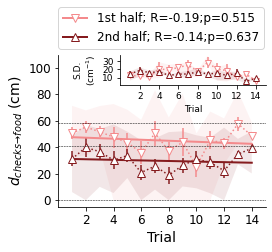

In [5]:
"""
###############
###############
###############
###############
############### d_holes AVERAGE DIST CHECKED HOLES TO TARGET
###############
###############
###############
###############
"""

d_intertarget = plib.get_intertarget_distance_static_entrance()

# calculating the slowing down instants and positions in the 3 cm radius of holes
hole_horizon = 3.0 # in cm (units is mouse.unit_r)

# d == perpendicular distance to food line; first index -> trial, second index -> mouse
d_holes_h1 = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False) for all_mice in all_trials_ft_h1 ]
d_holes_h2 = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False) for all_mice in all_trials_ft_h2 ]

#######
####### calculating time and mouse averages
#######

# each item in the list below containes the average d for each mice
d_holes_hmean_sd_err_h1 = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in d_holes_h1 ] # axis=1 -> average over holes (hmean)
d_holes_mmean_sd_err_h1 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill([ trial[0] for trial in d_holes_hmean_sd_err_h1 ]),axis=1)).T # trial[0] -> mean of each mice

d_holes_hmean_sd_err_h2 = [ misc.mean_std_err_minmax(misc.asarray_nanfill(all_mice),axis=1) for all_mice in d_holes_h2 ] # axis=1 -> average over holes (hmean)
d_holes_mmean_sd_err_h2 = numpy.array(misc.mean_std_err_minmax(misc.asarray_nanfill([ trial[0] for trial in d_holes_hmean_sd_err_h2 ]),axis=1)).T # trial[0] -> mean of each mice
# col0 -> mean
# col1 -> sd
# col2 -> se
# col3 -> min
# col4 -> max
# row -> trial (mean over mice)


# calculating the error of the standard deviation
# to be able to plot the standard deviation as a function of trial
d_holes_mstd_sd_minmax_h1 = numpy.array([numpy.fromiter(misc.flatten_list(misc.bootstrap_func(misc.nanmean(misc.asarray_nanfill(nn),axis=1),numpy.std,return_bs_confint_se=True)),dtype=float) for nn in d_holes_h1])
d_holes_mstd_sd_minmax_h2 = numpy.array([numpy.fromiter(misc.flatten_list(misc.bootstrap_func(misc.nanmean(misc.asarray_nanfill(nn),axis=1),numpy.std,return_bs_confint_se=True)),dtype=float) for nn in d_holes_h2])
# col0 -> stddev
# col1 -> min stddev 0.95 confint
# col2 -> max stddev 0.95 confint
# col3 -> StdErr of stddev 0.95 confint


#######
####### calculating the z-scores
#######

# using the random entrance (i.e. fixed target ft) as control trials
d_holes_Z_h1,d_holes_Z_h2  = misc.zscore_to_control(  misc.asarray_nanfill([ trial[0] for trial in d_holes_hmean_sd_err_h1[:n_trials] ]), misc.asarray_nanfill([ trial[0] for trial in d_holes_hmean_sd_err_h2[:n_trials] ])   , axis=1)
d_holes_mmean_sd_err_Z_h1 = numpy.array(misc.mean_std_err_minmax(d_holes_Z_h1,axis=1)).T
d_holes_mmean_sd_err_Z_h2 = numpy.array(misc.mean_std_err_minmax(d_holes_Z_h2,axis=1)).T

#######
####### calculating distributions
#######

n_bins = 25
P_d_holes_h1 = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in d_holes_h1 ]
P_d_holes_h2 = [ tran.calc_distribution(all_mice,n_bins=25,return_as_struct=True) for all_mice in d_holes_h2 ]

#######
####### calculating correlation with trial n
#######

linearize_func   = lambda x:x #numpy.log
linreg_func      = linreg_lin_func # linreg_exp_func
linearize_func_Z = lambda x:x#numpy.log
linreg_func_Z    = linreg_lin_func

d_holes_linreg_trial_h1   = misc.linregress(numpy.arange(n_trials_h1),     linearize_func(d_holes_mmean_sd_err_h1[:n_trials_h1,0]), alternative='two-sided')
d_holes_linreg_trial_h2   = misc.linregress(numpy.arange(n_trials_h2),     linearize_func(d_holes_mmean_sd_err_h2[:n_trials_h2,0]), alternative='two-sided')
d_holes_Z_linreg_trial_h1 = misc.linregress(numpy.arange(n_trials)   ,   linearize_func_Z(d_holes_mmean_sd_err_Z_h1[:,0]         ), alternative='two-sided')
d_holes_Z_linreg_trial_h2 = misc.linregress(numpy.arange(n_trials)   ,   linearize_func_Z(d_holes_mmean_sd_err_Z_h2[:,0]         ), alternative='two-sided')

#######
####### t-test
#######

# comparing each trial of rt vs. ft
d_holes_ttest_trials  = scipy.stats.ttest_ind(d_holes_Z_h1,d_holes_Z_h2,axis=1,equal_var=False,nan_policy='omit',alternative='two-sided')
k_significant_trials = misc.check_p_values(d_holes_ttest_trials,p_significant,q_FDR) # index of significant trials

# comparing first with last trial
d_holes_ttest_first_last_h1 = scipy.stats.ttest_ind(d_holes_hmean_sd_err_h1[0][0],d_holes_hmean_sd_err_h1[n_trials_h1-1][0],equal_var=False,nan_policy='omit',alternative='two-sided')
d_holes_ttest_first_last_h2 = scipy.stats.ttest_ind(d_holes_hmean_sd_err_h2[0][0],d_holes_hmean_sd_err_h2[n_trials_h2-1][0],equal_var=False,nan_policy='omit',alternative='two-sided')

ttest_result  = 'AVG CHECKED HOLE DISTANCE TO TARGET\n\n'
ttest_result += ' *** T-Test between first and last trials' + '\n\n'
ttest_result += f'     1st half (1 vs. {n_trials_h1})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(d_holes_ttest_first_last_h1.statistic,d_holes_ttest_first_last_h1.pvalue,'(*)' if check_significance(d_holes_ttest_first_last_h1) else '   ') + '\n'
ttest_result += f'     2nd half (1 vs. {n_trials_h2})' + '{2:s}:: T = {0:.8g}     p = {1:.8g}'.format(d_holes_ttest_first_last_h2.statistic,d_holes_ttest_first_last_h2.pvalue,'(*)' if check_significance(d_holes_ttest_first_last_h2) else '   ') + '\n'
ttest_result += ' ' + '\n'
print(ttest_result)

#######
####### calculating correlation with trial n
#######
#fh = plt.figure(figsize=(4,3))
#ax = plt.gca()
fh,axh = plt.subplots(nrows=1,ncols=2,sharex=False,sharey=False,figsize=FIGSIZE_1PANEL)

ax=axh[0]
ax.set_position(list(AX_POS_1PANEL[:2])+list(AX_POS_1PANEL[2:]*0.8))
pltt.plot_errorfill(numpy.arange(n_trials_h1)+1,d_holes_mmean_sd_err_h1[:n_trials_h1,0],[d_holes_mmean_sd_err_h1[:n_trials_h1,-2],d_holes_mmean_sd_err_h1[:n_trials_h1,-1]],fmt=':',color=color_ft_h1,ax=ax,markersize=4,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials_h2)+1,d_holes_mmean_sd_err_h2[:n_trials_h2,0],[d_holes_mmean_sd_err_h2[:n_trials_h2,-2],d_holes_mmean_sd_err_h2[:n_trials_h2,-1]],fmt=':',color=color_ft_h2,ax=ax,markersize=3,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials_h1)+1,d_holes_mmean_sd_err_h1[:n_trials_h1,0],d_holes_mmean_sd_err_h1[:n_trials_h1,2],fmt='v',color=color_ft_h1,markersize=8,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials_h2)+1,d_holes_mmean_sd_err_h2[:n_trials_h2,0],d_holes_mmean_sd_err_h2[:n_trials_h2,2],fmt='^',color=color_ft_h2,markersize=8,markerfacecolor='w')
ax.plot(numpy.arange(n_trials_h1)+1,linreg_func(numpy.arange(n_trials_h1)+1,d_holes_linreg_trial_h1),'-',color=color_ft_h1,linewidth=2)
ax.plot(numpy.arange(n_trials_h2)+1,linreg_func(numpy.arange(n_trials_h2)+1,d_holes_linreg_trial_h2),'-',color=color_ft_h2,linewidth=2)
line_leg_h1 = plt.Line2D([numpy.nan],[numpy.nan],linewidth=2,color=color_ft_h1,markersize=8,marker='v',markerfacecolor='w',label='1st half; R={0:.2g};p={1:.3g}'.format(d_holes_linreg_trial_h1.rvalue,d_holes_linreg_trial_h1.pvalue))
line_leg_h2 = plt.Line2D([numpy.nan],[numpy.nan],linewidth=2,color=color_ft_h2,markersize=8,marker='^',markerfacecolor='w',label='2nd half; R={0:.2g};p={1:.3g}'.format(d_holes_linreg_trial_h2.rvalue,d_holes_linreg_trial_h2.pvalue))
pltt.plot_horizontal_lines((0,)+d_intertarget,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=0,xMax=n_trials+1)
#ax.set_yscale('log')
ax.set_xticks(numpy.arange(numpy.max((n_trials_h2,n_trials_h1))+1)[2::2])
ax.set_xlim(0,numpy.max((n_trials_h2,n_trials_h1))+1)
ax.set_ylim((-5,110))
ax.legend(handles=[line_leg_h1,line_leg_h2],loc='lower right', bbox_to_anchor=(1.02, 1))
ax.set_xlabel('Trial')
ax.set_ylabel('$d_{checks\\to food}$ (cm)')


#fh = plt.figure(figsize=(4,3))
#ax = plt.gca()
ax=axh[1]
p0 = axh[0].get_position()
frac_w = 0.7
frac_h = 0.8
ax.set_position([ p0.x0+(1-frac_w)*p0.width,p0.y0+frac_h*p0.height,p0.width*frac_w,p0.height*(1-frac_h) ])
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_holes_mmean_sd_err_h1[:n_trials,1],[d_holes_mstd_sd_minmax_h1[:n_trials,1],d_holes_mstd_sd_minmax_h1[:n_trials,2]],fmt=':',color=color_ft_h1,ax=ax,markersize=4,absolute_err=True,alpha_fill=0.1)
pltt.plot_errorfill(numpy.arange(n_trials)+1,d_holes_mmean_sd_err_h2[:n_trials,1],[d_holes_mstd_sd_minmax_h2[:n_trials,1],d_holes_mstd_sd_minmax_h2[:n_trials,2]],fmt=':',color=color_ft_h2,ax=ax,markersize=3,absolute_err=True,alpha_fill=0.1)
ax.errorbar(numpy.arange(n_trials)+1,d_holes_mmean_sd_err_h1[:n_trials,1],d_holes_mstd_sd_minmax_h1[:n_trials,-1],fmt='v',label='1st half',color=color_ft_h1,markersize=6,markerfacecolor='w')
ax.errorbar(numpy.arange(n_trials)+1,d_holes_mmean_sd_err_h2[:n_trials,1],d_holes_mstd_sd_minmax_h2[:n_trials,-1],fmt='^',label='2nd half',color=color_ft_h2,markersize=6,markerfacecolor='w')
ax.set_xticks(numpy.arange(n_trials+1)[2::2])
ax.set_xlim(0,n_trials+1)
ax.set_xlabel('Trial',                   fontsize = 9 )
ax.set_ylabel('S.D.\n(cm$^{-1}$)',       fontsize = 9 )
ax.tick_params(axis='both',which='major',labelsize= 9 )

pltt.set_box_axis(axh,False)

if save_output_figures:
    plt.savefig(  f'{output_dir}/rand_half_trials_holedist.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    numpy.savetxt(f'{output_dir}/rand_half_trials_holedist_ttest.txt',numpy.array([[]]),header=ttest_result)

plt.show()

# DISTRIBUTIONS OF BOTH CONDITIONS

### P(dist) probability of checking in distance

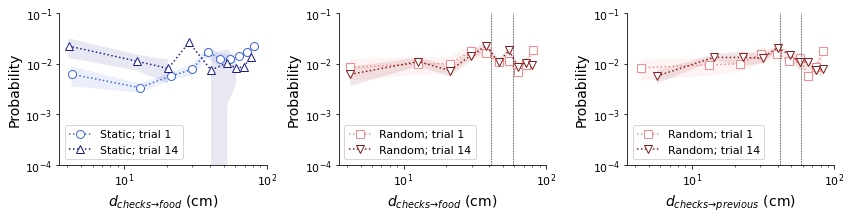

In [6]:
"""
###############
###############
###############
###############
############### P of d_holes -- real target, trimmed trajectories
###############
###############
###############
###############
"""


d_intertarget = plib.get_intertarget_distance_static_entrance()

align_entrances = False

ignore_entrance_positions = False

all_trials_rt_rot = plib.rotate_trial_file(copy.deepcopy(all_trials_rt),(-1,1),True)
all_trials_ft_rot = plib.align_targets_group_by_start_quadrant(all_trials_ft,(-1,1))

r_target_prev_ft = [ tr[0].r_target for tr in all_trials_ft_rot ]
r_target_prev_ft = [ all_trials_ft_rot[0][0].r_target ] + r_target_prev_ft[:-1]
 #plib.rotate_trial_file(copy.deepcopy(all_trials_ft),(-1,1),True) if align_entrances else plib.align_targets(copy.deepcopy(all_trials_ft),(1,0))

# calculating the slowing down instants and positions in the 3 cm radius of holes
n_bins                  = 10
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s

#######
####### calculating distributions
#######

d_holes_rt      = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice       in all_trials_rt_rot                       ]
d_holes_ft      = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice       in all_trials_ft_rot                       ]
d_holes_prev_ft = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions, r_target=r_tgt,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice,r_tgt in zip(all_trials_ft_rot,r_target_prev_ft) ]

P_d_holes_rt      = [ tran.calc_distribution(all_mice  ,n_bins=n_bins,return_as_struct=True,binning='linear',join_samples=False,replace_Peq0_by_nan=True,remove_Peq0=True) for all_mice in d_holes_rt      ]
P_d_holes_ft      = [ tran.calc_distribution(all_mice  ,n_bins=n_bins,return_as_struct=True,binning='linear',join_samples=False,replace_Peq0_by_nan=True,remove_Peq0=True) for all_mice in d_holes_ft      ]
P_d_holes_prev_ft = [ tran.calc_distribution(all_mice  ,n_bins=n_bins,return_as_struct=True,binning='linear',join_samples=False,replace_Peq0_by_nan=True,remove_Peq0=True) for all_mice in d_holes_prev_ft ]


ax_label_fontsize = 14
ax_ticks_fontsize = 11


fh,axh = plt.subplots(nrows=1,ncols=3,sharex=True,sharey=True,figsize=2*FIGSIZE_1PANEL)
ax_pos = AX_POS_1PANEL.copy()
ax_pos[2] *= 0.8
ax_pos[3] *= 0.8
AX_POS_2PANELS_mod = numpy.array([   ax_pos/2.0,
                                 [ 1.5*ax_pos[0]+ax_pos[2]/2      ,ax_pos[1]/2,ax_pos[2]/2,ax_pos[3]/2 ],
                                 [ 1.75*1.5*ax_pos[0]+2*ax_pos[2]/2,ax_pos[1]/2,ax_pos[2]/2,ax_pos[3]/2 ] ])
axh[0].set_position(AX_POS_2PANELS_mod[0])
axh[1].set_position(AX_POS_2PANELS_mod[1])
axh[2].set_position(AX_POS_2PANELS_mod[2])
ax=axh[0]
pltt.plot_errorfill(P_d_holes_rt[0].x ,P_d_holes_rt[0].P ,P_d_holes_rt[0].Pse ,fmt=':o',ax=ax,color=color_lightblue, markersize=8, markerfacecolor='w', alpha_fill=0.1, label='Static; trial 1')
pltt.plot_errorfill(P_d_holes_rt[-1].x,P_d_holes_rt[-1].P,P_d_holes_rt[-1].Pse,fmt=':^',ax=ax,color=color_darkblue , markersize=8, markerfacecolor='w', alpha_fill=0.1, label='Static; trial 14')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$d_{checks\\to food}$ (cm)', fontsize=ax_label_fontsize)
ax.set_ylabel('Probability',                fontsize=ax_label_fontsize)
ax.set_xlim(right=100)
ax.set_ylim((1e-4,1e-1))
ax.legend(loc='lower left',fontsize=11)
ax.tick_params(axis='y',   which='minor',length=0)
ax.tick_params(axis='both',which='major',labelsize=ax_ticks_fontsize)


ax=axh[1]
pltt.plot_errorfill(P_d_holes_ft[0].x ,P_d_holes_ft[0].P ,P_d_holes_ft[0].Pse ,fmt=':s',ax=ax,color=color_lightred , markersize=8, markerfacecolor='w', alpha_fill=0.1, label='Random; trial 1')
pltt.plot_errorfill(P_d_holes_ft[-1].x,P_d_holes_ft[-1].P,P_d_holes_ft[-1].Pse,fmt=':v',ax=ax,color=color_darkred  , markersize=8, markerfacecolor='w', alpha_fill=0.1, label='Random; trial 14')
pltt.plot_vertical_lines(d_intertarget,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$d_{checks\\to food}$ (cm)', fontsize=ax_label_fontsize)
ax.set_ylabel('Probability',                fontsize=ax_label_fontsize)
ax.set_xlim(right=100)
ax.set_ylim((1e-4,1e-1))
#ax.set_yticklabels(axh[0].get_yticklabels())
ax.yaxis.set_tick_params(labelleft=True)
ax.legend(loc='lower left',fontsize=11)
ax.tick_params(axis='y',   which='minor',length=0)
ax.tick_params(axis='both',which='major',labelsize=ax_ticks_fontsize)



ax=axh[2]
pltt.plot_errorfill(P_d_holes_prev_ft[0].x ,P_d_holes_prev_ft[0].P ,P_d_holes_prev_ft[0].Pse ,fmt=':s',ax=ax,color=color_lightred , markersize=8, markerfacecolor='w', alpha_fill=0.1, label='Random; trial 1')
pltt.plot_errorfill(P_d_holes_prev_ft[-1].x,P_d_holes_prev_ft[-1].P,P_d_holes_prev_ft[-1].Pse,fmt=':v',ax=ax,color=color_darkred  , markersize=8, markerfacecolor='w', alpha_fill=0.1, label='Random; trial 14')
pltt.plot_vertical_lines(d_intertarget,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$d_{checks\\to previous}$ (cm)', fontsize=ax_label_fontsize)
ax.set_ylabel('Probability',                    fontsize=ax_label_fontsize)
ax.set_xlim(right=100)
ax.set_ylim((1e-4,1e-1))
#ax.set_yticklabels(axh[0].get_yticklabels())
ax.yaxis.set_tick_params(labelleft=True)
ax.legend(loc='lower left',fontsize=11)
ax.tick_params(axis='y',   which='minor',length=0)
ax.tick_params(axis='both',which='major',labelsize=ax_ticks_fontsize)


pltt.set_box_axis(axh,False)

if save_output_figures:
    plt.savefig(  f'{output_dir}/distribution_hole_distance_tgt-real_traj-trim.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

# HOLE CHECKS BAR PLOTS

### barplot near vs. far target

#### loading extra data

In [2]:
# experiments where mice are trained in "static entrance protocol" until first probe at least
# 2019-05-23 # preliminary
# 2021-06-22 # two targets
# 2021-11-19 # two targets
# 2022-08-12 # two targets rotated probe
# 2022-09-20 # two targets with rotated probe (female mice)
# 2022-10-11 # two targets rotated probe mixed sex
# 2022-11-04 # relative target (aka static entrance) - after trial 21 (at the probe), two mice (out of 4) get 90 degrees rotation

mouse_traj_dir_rt_1     = r'./experiments/relative_target/mouse_*'
#mouse_traj_dir_rt_2     = r'./experiments/preliminary/mouse_*'
mouse_traj_dir_rt_3     = r'./experiments/two_target_no_cues/mouse_*'
mouse_traj_dir_rt_4     = r'./experiments/two_targets_rot/mouse_*'
mouse_traj_dir_rt_5     = r'./experiments/two_targets_rot_fem/mouse_*'
mouse_traj_dir_rt_6     = r'./experiments/two_targets_rot_mixsex/mouse_*'
mouse_traj_dir_rt_7     = r'./experiments/relative_target_90deg/mouse_*'
time_delay_after_food  = 3.0 # sec
n_trial_max            = 14

trials_for_nchecks_1,_       = io.load_trial_file(mouse_traj_dir_rt_1,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
#trials_for_nchecks_2,_       = io.load_trial_file(mouse_traj_dir_rt_2,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_3,_       = io.load_trial_file(mouse_traj_dir_rt_3,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_4,_       = io.load_trial_file(mouse_traj_dir_rt_4,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_5,_       = io.load_trial_file(mouse_traj_dir_rt_5,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_6,_       = io.load_trial_file(mouse_traj_dir_rt_6,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_7,_       = io.load_trial_file(mouse_traj_dir_rt_7,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)

trials_for_nchecks_1         = tran.remove_path_after_food(trials_for_nchecks_1,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
#trials_for_nchecks_2         = tran.remove_path_after_food(trials_for_nchecks_2,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_3         = tran.remove_path_after_food(trials_for_nchecks_3,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_4         = tran.remove_path_after_food(trials_for_nchecks_4,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_5         = tran.remove_path_after_food(trials_for_nchecks_5,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_6         = tran.remove_path_after_food(trials_for_nchecks_6,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_7         = tran.remove_path_after_food(trials_for_nchecks_7,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)


# 14 trials, each containing 36 mice in "static entrance" condition
all_trials_for_rt_boxplot = io.group_track_list(misc.flatten_list([
        trials_for_nchecks_1,
        #trials_for_nchecks_2,
        trials_for_nchecks_3,
        trials_for_nchecks_4,
        trials_for_nchecks_5,
        trials_for_nchecks_6,
        trials_for_nchecks_7
    ],
    only_lists=True,return_list=True),group_by='trial',return_group_keys=False)

del trials_for_nchecks_1
del trials_for_nchecks_3
del trials_for_nchecks_4
del trials_for_nchecks_5
del trials_for_nchecks_6
del trials_for_nchecks_7

#### n=36 static entrance

 ... save  figs/paper/uncertainty_random_vs_static/NUM_checks_FAR_NEAR_static_ALL_MICE.png


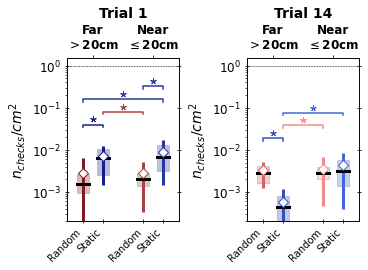

In [6]:
#import sys
#del sys.modules['modules.plot_func']
#del sys.modules['modules.helper_func_class']
#del pltt
#del misc
#import modules.plot_func as pltt
#import modules.helper_func_class as misc

"""
###############
###############
###############
###############
############### P of d_holes -- real target, trimmed trajectories
###############
###############
###############
###############
"""
calc_arena_area = lambda track: numpy.pi*(track.arena_diameter/2.0)**2

d_intertarget = plib.get_intertarget_distance_static_entrance()

align_entrances = False

ignore_entrance_positions = False

all_trials_rt_rot = plib.rotate_trial_file(copy.deepcopy(all_trials_for_rt_boxplot),(-1,1),True)
all_trials_ft_rot = plib.align_targets_group_by_start_quadrant(all_trials_ft,(-1,1))

r_target_prev_ft = [ tr[0].r_target for tr in all_trials_ft_rot ]
r_target_prev_ft = [ all_trials_ft_rot[0][0].r_target ] + r_target_prev_ft[:-1]
 #plib.rotate_trial_file(copy.deepcopy(all_trials_ft),(-1,1),True) if align_entrances else plib.align_targets(copy.deepcopy(all_trials_ft),(1,0))

# calculating the slowing down instants and positions in the 3 cm radius of holes
n_bins                  = 10
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s

hole_proximity_radius_threshold = 20.0 # cm

area_arena    = calc_arena_area(all_trials_rt_rot[0][0])
area_near_tgt = numpy.pi * hole_proximity_radius_threshold**2
area_far_tgt  = area_arena - area_near_tgt

#######
####### calculating distributions
#######

d_holes_rt      = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice       in all_trials_rt_rot                       ]
d_holes_ft      = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice       in all_trials_ft_rot                       ]

n_checks_near_rt = numpy.asarray([ [ numpy.nonzero(d <= hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_rt ],dtype=float)/area_near_tgt
n_checks_far_rt  = numpy.asarray([ [ numpy.nonzero(d  > hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_rt ],dtype=float)/area_far_tgt
n_checks_near_ft = numpy.asarray([ [ numpy.nonzero(d <= hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_ft ],dtype=float)/area_near_tgt
n_checks_far_ft  = numpy.asarray([ [ numpy.nonzero(d  > hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_ft ],dtype=float)/area_far_tgt


far_near_label   = ['Far\n$>${:g}cm'.format(hole_proximity_radius_threshold),'Near\n$\\leq${:g}cm'.format(hole_proximity_radius_threshold)]

color_palette_rt = pltt.get_gradient_between(color_darkblue,color_lightblue,4) #plt.get_cmap('tab20c')(numpy.linspace(0,1,20))[:4,:]
data_labels_rt   = ['Static', 'Static', 'Static', 'Static'] #['Trial 1 Far', 'Trial 1 Near', 'Trial 14 Far', 'Trial 14 Near']
data_rt          = [n_checks_far_rt[0]   ,
                    n_checks_near_rt[0]  ,
                    n_checks_far_rt[-1]  ,
                    n_checks_near_rt[-1] ]

color_palette_ft = pltt.get_gradient_between(color_darkred,color_lightred,4) #plt.get_cmap('tab20c')(numpy.linspace(0,1,20))[4:8,:]
data_labels_ft   = ['Random', 'Random', 'Random', 'Random'] #['Trial 1 Far', 'Trial 1 Near', 'Trial 14 Far', 'Trial 14 Near']
data_ft          = [n_checks_far_ft[0]   ,
                    n_checks_near_ft[0]  ,
                    n_checks_far_ft[-1]  ,
                    n_checks_near_ft[-1] ]



data          = misc.intertwin_vectors(data_ft,data_rt) #copy.deepcopy(data_rt)
data_labels   = misc.intertwin_vectors(data_labels_ft,data_labels_rt)
positions     = misc.intertwin_vectors(numpy.arange(0,10,3),numpy.arange(0,10,3)+1)
color_palette = misc.intertwin_vectors(color_palette_ft,color_palette_rt)

get_pvalue_matrix    = lambda data: numpy.array([ scipy.stats.ttest_ind(dd,misc.asarray_nanfill(data).T,equal_var=False,nan_policy='omit',alternative='two-sided').pvalue for dd in data ])
get_ttest_matrix     = lambda data: numpy.tril(misc.check_p_values(get_pvalue_matrix(data),p_significant,q_threshold=q_FDR),-1)
significance_matrix  = get_ttest_matrix(data)  #numpy.zeros(significance_matrix.shape)
significance_trial1  = get_ttest_matrix(data[:4])
significance_trial14 = get_ttest_matrix(data[4:])

ax_label_fontsize = 14
ax_ticks_fontsize = 11


fig,axh = plt.subplots(ncols=2,nrows=1,figsize=(2*FIGSIZE_1PANEL[0]/1.8,FIGSIZE_1PANEL[1]))


ax=axh[0]
ax     = pltt.plot_boxplot(ax,data[:4],data_labels[:4],color_palette[:4],significance_trial1,is_log_scale=True,positions=positions[:4],
                           boxplotargs  = dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),
                           errorbarargs = dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.8,xMax=numpy.max(positions[:4])+0.8)
ax.set_title('Trial 1',fontsize=14,fontweight='bold')
ax.set_yscale('log')
ax.set_xlim(-0.8,numpy.max(positions[:4])+0.8)
ax.set_xlabel('')
ax.set_ylabel('$n_{checks}/cm^2$')#('Distance walked\nper target distance')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels[:4], fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks()[0::2]+0.5)
ax2.set_xticklabels(far_near_label, fontdict=dict(family='sans-serif',verticalalignment='bottom',horizontalalignment='center',size=12,fontweight='bold'))


ax = axh[1]
ax     = pltt.plot_boxplot(ax,data[4:],data_labels[4:],color_palette[4:],significance_trial14,is_log_scale=True,positions=positions[4:]-6.0,
                           boxplotargs  = dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),
                           errorbarargs = dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.8,xMax=numpy.max(positions[4:])-6.0+0.8)
ax.set_title('Trial 14',fontsize=14,fontweight='bold')
ax.set_yscale('log')
ax.set_xlim(-0.8,numpy.max(positions[4:])-6.0+0.8)
ax.set_ylim(axh[0].get_ylim())
ax.set_xlabel('')
ax.set_ylabel('$n_{checks}/cm^2$')#('Distance walked\nper target distance')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels[4:], fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks()[0::2]+0.5)
ax2.set_xticklabels(far_near_label, fontdict=dict(family='sans-serif',verticalalignment='bottom',horizontalalignment='center',size=12,fontweight='bold'))
p  = ax.get_position()
ax.set_position([p.x0+0.14,p.y0,p.width,p.height])
ax2.set_position(ax.get_position())


if save_output_figures:
    fileName =  f'{output_dir}/NUM_checks_FAR_NEAR_static_ALL_MICE.png'
    print(' ... save ', fileName)
    plt.savefig( fileName ,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


plt.show()

#### n=8 static entrance

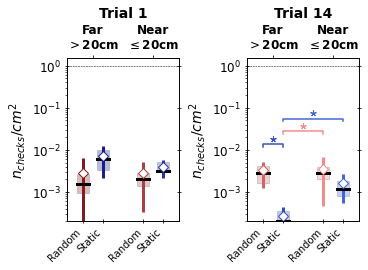

In [7]:
#import sys
#del sys.modules['modules.plot_func']
#del sys.modules['modules.helper_func_class']
#del pltt
#del misc
#import modules.plot_func as pltt
#import modules.helper_func_class as misc

"""
###############
###############
###############
###############
############### P of d_holes -- real target, trimmed trajectories
###############
###############
###############
###############
"""
calc_arena_area = lambda track: numpy.pi*(track.arena_diameter/2.0)**2

d_intertarget = plib.get_intertarget_distance_static_entrance()

align_entrances = False

ignore_entrance_positions = False

all_trials_rt_rot = plib.rotate_trial_file(copy.deepcopy(all_trials_rt),(-1,1),True)
all_trials_ft_rot = plib.align_targets_group_by_start_quadrant(all_trials_ft,(-1,1))

r_target_prev_ft = [ tr[0].r_target for tr in all_trials_ft_rot ]
r_target_prev_ft = [ all_trials_ft_rot[0][0].r_target ] + r_target_prev_ft[:-1]
 #plib.rotate_trial_file(copy.deepcopy(all_trials_ft),(-1,1),True) if align_entrances else plib.align_targets(copy.deepcopy(all_trials_ft),(1,0))

# calculating the slowing down instants and positions in the 3 cm radius of holes
n_bins                  = 10
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s

hole_proximity_radius_threshold = 20.0 # cm

area_arena    = calc_arena_area(all_trials_rt_rot[0][0])
area_near_tgt = numpy.pi * hole_proximity_radius_threshold**2
area_far_tgt  = area_arena - area_near_tgt

#######
####### calculating distributions
#######

d_holes_rt      = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice       in all_trials_rt_rot                       ]
d_holes_ft      = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice       in all_trials_ft_rot                       ]

n_checks_near_rt = numpy.asarray([ [ numpy.nonzero(d <= hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_rt ],dtype=float)/area_near_tgt
n_checks_far_rt  = numpy.asarray([ [ numpy.nonzero(d  > hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_rt ],dtype=float)/area_far_tgt
n_checks_near_ft = numpy.asarray([ [ numpy.nonzero(d <= hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_ft ],dtype=float)/area_near_tgt
n_checks_far_ft  = numpy.asarray([ [ numpy.nonzero(d  > hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_ft ],dtype=float)/area_far_tgt


far_near_label   = ['Far\n$>${:g}cm'.format(hole_proximity_radius_threshold),'Near\n$\\leq${:g}cm'.format(hole_proximity_radius_threshold)]

color_palette_rt = pltt.get_gradient_between(color_darkblue,color_lightblue,4) #plt.get_cmap('tab20c')(numpy.linspace(0,1,20))[:4,:]
data_labels_rt   = ['Static', 'Static', 'Static', 'Static'] #['Trial 1 Far', 'Trial 1 Near', 'Trial 14 Far', 'Trial 14 Near']
data_rt          = [n_checks_far_rt[0]   ,
                    n_checks_near_rt[0]  ,
                    n_checks_far_rt[-1]  ,
                    n_checks_near_rt[-1] ]

color_palette_ft = pltt.get_gradient_between(color_darkred,color_lightred,4) #plt.get_cmap('tab20c')(numpy.linspace(0,1,20))[4:8,:]
data_labels_ft   = ['Random', 'Random', 'Random', 'Random'] #['Trial 1 Far', 'Trial 1 Near', 'Trial 14 Far', 'Trial 14 Near']
data_ft          = [n_checks_far_ft[0]   ,
                    n_checks_near_ft[0]  ,
                    n_checks_far_ft[-1]  ,
                    n_checks_near_ft[-1] ]



data          = misc.intertwin_vectors(data_ft,data_rt) #copy.deepcopy(data_rt)
data_labels   = misc.intertwin_vectors(data_labels_ft,data_labels_rt)
positions     = misc.intertwin_vectors(numpy.arange(0,10,3),numpy.arange(0,10,3)+1)
color_palette = misc.intertwin_vectors(color_palette_ft,color_palette_rt)

get_pvalue_matrix    = lambda data: numpy.array([ scipy.stats.ttest_ind(dd,misc.asarray_nanfill(data).T,equal_var=False,nan_policy='omit',alternative='two-sided').pvalue for dd in data ])
get_ttest_matrix     = lambda data: numpy.tril(misc.check_p_values(get_pvalue_matrix(data),p_significant,q_threshold=q_FDR),-1)
significance_matrix  = get_ttest_matrix(data)  #numpy.zeros(significance_matrix.shape)
significance_trial1  = get_ttest_matrix(data[:4])
significance_trial14 = get_ttest_matrix(data[4:])

ax_label_fontsize = 14
ax_ticks_fontsize = 11


fig,axh = plt.subplots(ncols=2,nrows=1,figsize=(2*FIGSIZE_1PANEL[0]/1.8,FIGSIZE_1PANEL[1]))


ax=axh[0]
ax     = pltt.plot_boxplot(ax,data[:4],data_labels[:4],color_palette[:4],significance_trial1,is_log_scale=True,positions=positions[:4],
                           boxplotargs  = dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),
                           errorbarargs = dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.8,xMax=numpy.max(positions[:4])+0.8)
ax.set_title('Trial 1',fontsize=14,fontweight='bold')
ax.set_yscale('log')
ax.set_xlim(-0.8,numpy.max(positions[:4])+0.8)
ax.set_xlabel('')
ax.set_ylabel('$n_{checks}/cm^2$')#('Distance walked\nper target distance')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels[:4], fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks()[0::2]+0.5)
ax2.set_xticklabels(far_near_label, fontdict=dict(family='sans-serif',verticalalignment='bottom',horizontalalignment='center',size=12,fontweight='bold'))


ax = axh[1]
ax     = pltt.plot_boxplot(ax,data[4:],data_labels[4:],color_palette[4:],significance_trial14,is_log_scale=True,positions=positions[4:]-6.0,
                           boxplotargs  = dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),
                           errorbarargs = dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.8,xMax=numpy.max(positions[4:])-6.0+0.8)
ax.set_title('Trial 14',fontsize=14,fontweight='bold')
ax.set_yscale('log')
ax.set_xlim(-0.8,numpy.max(positions[4:])-6.0+0.8)
ax.set_ylim(axh[0].get_ylim())
ax.set_xlabel('')
ax.set_ylabel('$n_{checks}/cm^2$')#('Distance walked\nper target distance')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels[4:], fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks()[0::2]+0.5)
ax2.set_xticklabels(far_near_label, fontdict=dict(family='sans-serif',verticalalignment='bottom',horizontalalignment='center',size=12,fontweight='bold'))
p  = ax.get_position()
ax.set_position([p.x0+0.14,p.y0,p.width,p.height])
ax2.set_position(ax.get_position())


if save_output_figures:
    plt.savefig(  f'{output_dir}/NUM_checks_FAR_NEAR.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


plt.show()

### barplot PROBE near vs far

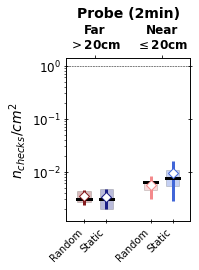

In [2]:
#import sys
#del sys.modules['modules.plot_func']
#del sys.modules['modules.helper_func_class']
#del pltt
#del misc
#import modules.plot_func as pltt
#import modules.helper_func_class as misc

"""
###############
###############
###############
###############
############### P of d_holes -- real target, trimmed trajectories
###############
###############
###############
###############
"""

calc_arena_area = lambda track: numpy.pi*(track.arena_diameter/2.0)**2

all_probe_rt = plib.rotate_trial_file(tran.slice_track_by_time(io.load_trial_file(mouse_traj_dir_rt,file_name_expr='mpos_*Probe_*',fix_nan=True,sort_by_trial=True,return_group_by_keys=False,remove_after_food=False),0.0,t1=120.0,copy_track=True),ref_vector=(0,1),return_only_track=True)
all_probe_ft = plib.rotate_trial_file(tran.slice_track_by_time(io.load_trial_file(mouse_traj_dir_ft,file_name_expr='mpos_*Probe_*',fix_nan=True,sort_by_trial=True,return_group_by_keys=False,remove_after_food=False),0.0,t1=120.0,copy_track=True),ref_vector=(0,1),return_only_track=True)

d_intertarget = plib.get_intertarget_distance_static_entrance()

align_entrances = False

ignore_entrance_positions = False


# calculating the slowing down instants and positions in the 3 cm radius of holes
n_bins                  = 10
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s

hole_proximity_radius_threshold = 20.0 # cm

area_arena    = calc_arena_area(all_probe_rt[0])
area_near_tgt = numpy.pi * hole_proximity_radius_threshold**2
area_far_tgt  = area_arena - area_near_tgt

#######
####### calculating distributions
#######

d_holes_rt      = tran.calc_dist_checked_holes_target(all_probe_rt,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)
d_holes_ft      = tran.calc_dist_checked_holes_target(all_probe_ft,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)

n_checks_near_rt = numpy.asarray(  [ numpy.nonzero(d <= hole_proximity_radius_threshold)[0].size for d in d_holes_rt ],dtype=float)/area_near_tgt
n_checks_far_rt  = numpy.asarray(  [ numpy.nonzero(d  > hole_proximity_radius_threshold)[0].size for d in d_holes_rt ],dtype=float)/area_far_tgt
n_checks_near_ft = numpy.asarray(  [ numpy.nonzero(d <= hole_proximity_radius_threshold)[0].size for d in d_holes_ft ],dtype=float)/area_near_tgt
n_checks_far_ft  = numpy.asarray(  [ numpy.nonzero(d  > hole_proximity_radius_threshold)[0].size for d in d_holes_ft ],dtype=float)/area_far_tgt


far_near_label   = ['Far\n$>${:g}cm'.format(hole_proximity_radius_threshold),'Near\n$\\leq${:g}cm'.format(hole_proximity_radius_threshold)]

color_palette_rt = pltt.get_gradient_between(color_darkblue,color_lightblue,2) #plt.get_cmap('tab20c')(numpy.linspace(0,1,20))[:4,:]
data_labels_rt   = ['Static', 'Static'] #['Trial 1 Far', 'Trial 1 Near', 'Trial 14 Far', 'Trial 14 Near']
data_rt          = [n_checks_far_rt   ,
                    n_checks_near_rt  ]

color_palette_ft = pltt.get_gradient_between(color_darkred,color_lightred,2) #plt.get_cmap('tab20c')(numpy.linspace(0,1,20))[4:8,:]
data_labels_ft   = ['Random', 'Random'] #['Trial 1 Far', 'Trial 1 Near', 'Trial 14 Far', 'Trial 14 Near']
data_ft          = [n_checks_far_ft   ,
                    n_checks_near_ft  ]



data          = misc.intertwin_vectors(data_ft,data_rt) #copy.deepcopy(data_rt)
data_labels   = misc.intertwin_vectors(data_labels_ft,data_labels_rt)
positions     = misc.intertwin_vectors(numpy.arange(0,5,3),numpy.arange(0,5,3)+1)
color_palette = misc.intertwin_vectors(color_palette_ft,color_palette_rt)

get_pvalue_matrix    = lambda data: numpy.array([ scipy.stats.ttest_ind(dd,misc.asarray_nanfill(data).T,equal_var=False,nan_policy='omit',alternative='two-sided').pvalue for dd in data ])
get_ttest_matrix     = lambda data: numpy.tril(misc.check_p_values(get_pvalue_matrix(data),p_significant,q_threshold=q_FDR),-1)
significance_matrix  = get_ttest_matrix(data)  #numpy.zeros(significance_matrix.shape)

ax_label_fontsize = 14
ax_ticks_fontsize = 11


fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(FIGSIZE_1PANEL[0]/1.8,FIGSIZE_1PANEL[1]))

ax     = pltt.plot_boxplot(ax,data,data_labels,color_palette,significance_matrix,is_log_scale=True,positions=positions,
                           boxplotargs  = dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),
                           errorbarargs = dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.8,xMax=numpy.max(positions)+0.8)
ax.set_title('Probe (2min)',fontsize=14,fontweight='bold')
ax.set_yscale('log')
ax.set_xlim(-0.8,numpy.max(positions)+0.8)
ax.set_xlabel('')
ax.set_ylabel('$n_{checks}/cm^2$')#('Distance walked\nper target distance')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels, fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks()[0::2]+0.5)
ax2.set_xticklabels(far_near_label, fontdict=dict(family='sans-serif',verticalalignment='bottom',horizontalalignment='center',size=12,fontweight='bold'))


if save_output_figures:
    plt.savefig(  f'{output_dir}/NUM_checks_PROBE_FAR_NEAR.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


plt.show()

### barplot REL near vs. far

In [ ]:
#import sys
#del sys.modules['modules.plot_func']
#del sys.modules['modules.helper_func_class']
#del pltt
#del misc
#import modules.plot_func as pltt
#import modules.helper_func_class as misc

"""
###############
###############
###############
###############
############### P of d_holes -- real target, trimmed trajectories
###############
###############
###############
###############
"""

mouse_traj_dir_rel = './experiments/relative_target/mouse_*'

all_trials_rt,trial_labels_rt       = io.load_trial_file(mouse_traj_dir_rt,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True)
all_trials_rt                       = tran.remove_path_after_food(all_trials_rt,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)

all_probe_rel = plib.rotate_trial_file(
    tran.slice_track_by_time(
                io.load_trial_file(mouse_traj_dir_rt,file_name_expr='mpos_*Probe_*',fix_nan=True,sort_by_trial=True,return_group_by_keys=False,remove_after_food=False),
            0.0,t1=120.0,copy_track=True),
        ref_vector=(0,1),return_only_track=True)


calc_arena_area = lambda track: numpy.pi*(track.arena_diameter/2.0)**2

d_intertarget = plib.get_intertarget_distance_static_entrance()

align_entrances = False

ignore_entrance_positions = False

all_trials_rt_rot = plib.rotate_trial_file(copy.deepcopy(all_trials_rt),(-1,1),True)
all_trials_ft_rot = plib.align_targets_group_by_start_quadrant(all_trials_ft,(-1,1))

 #plib.rotate_trial_file(copy.deepcopy(all_trials_ft),(-1,1),True) if align_entrances else plib.align_targets(copy.deepcopy(all_trials_ft),(1,0))

# calculating the slowing down instants and positions in the 3 cm radius of holes
n_bins                  = 10
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s

hole_proximity_radius_threshold = 20.0 # cm

area_arena    = calc_arena_area(all_trials_rt_rot[0][0])
area_near_tgt = numpy.pi * hole_proximity_radius_threshold**2
area_far_tgt  = area_arena - area_near_tgt

#######
####### calculating distributions
#######

d_holes_rt      = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice       in all_trials_rt_rot                       ]
d_holes_ft      = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice       in all_trials_ft_rot                       ]

n_checks_near_rt = numpy.asarray([ [ numpy.nonzero(d <= hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_rt ],dtype=float)/area_near_tgt
n_checks_far_rt  = numpy.asarray([ [ numpy.nonzero(d  > hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_rt ],dtype=float)/area_far_tgt
n_checks_near_ft = numpy.asarray([ [ numpy.nonzero(d <= hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_ft ],dtype=float)/area_near_tgt
n_checks_far_ft  = numpy.asarray([ [ numpy.nonzero(d  > hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_ft ],dtype=float)/area_far_tgt


far_near_label   = ['Far\n$>${:g}cm'.format(hole_proximity_radius_threshold),'Near\n$\\leq${:g}cm'.format(hole_proximity_radius_threshold)]

color_palette_rt = pltt.get_gradient_between(color_darkblue,color_lightblue,4) #plt.get_cmap('tab20c')(numpy.linspace(0,1,20))[:4,:]
data_labels_rt   = ['Static', 'Static', 'Static', 'Static'] #['Trial 1 Far', 'Trial 1 Near', 'Trial 14 Far', 'Trial 14 Near']
data_rt          = [n_checks_far_rt[0]   ,
                    n_checks_near_rt[0]  ,
                    n_checks_far_rt[-1]  ,
                    n_checks_near_rt[-1] ]

color_palette_ft = pltt.get_gradient_between(color_darkred,color_lightred,4) #plt.get_cmap('tab20c')(numpy.linspace(0,1,20))[4:8,:]
data_labels_ft   = ['Random', 'Random', 'Random', 'Random'] #['Trial 1 Far', 'Trial 1 Near', 'Trial 14 Far', 'Trial 14 Near']
data_ft          = [n_checks_far_ft[0]   ,
                    n_checks_near_ft[0]  ,
                    n_checks_far_ft[-1]  ,
                    n_checks_near_ft[-1] ]



data          = misc.intertwin_vectors(data_ft,data_rt) #copy.deepcopy(data_rt)
data_labels   = misc.intertwin_vectors(data_labels_ft,data_labels_rt)
positions     = misc.intertwin_vectors(numpy.arange(0,10,3),numpy.arange(0,10,3)+1)
color_palette = misc.intertwin_vectors(color_palette_ft,color_palette_rt)

get_pvalue_matrix    = lambda data: numpy.array([ scipy.stats.ttest_ind(dd,misc.asarray_nanfill(data).T,equal_var=False,nan_policy='omit',alternative='two-sided').pvalue for dd in data ])
get_ttest_matrix     = lambda data: numpy.tril(misc.check_p_values(get_pvalue_matrix(data),p_significant,q_threshold=q_FDR),-1)
significance_matrix  = get_ttest_matrix(data)  #numpy.zeros(significance_matrix.shape)
significance_trial1  = get_ttest_matrix(data[:4])
significance_trial14 = get_ttest_matrix(data[4:])

ax_label_fontsize = 14
ax_ticks_fontsize = 11


fig,axh = plt.subplots(ncols=2,nrows=1,figsize=(2*FIGSIZE_1PANEL[0]/1.8,FIGSIZE_1PANEL[1]))


ax=axh[0]
ax     = pltt.plot_boxplot(ax,data[:4],data_labels[:4],color_palette[:4],significance_trial1,is_log_scale=True,positions=positions[:4],
                           boxplotargs  = dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),
                           errorbarargs = dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.8,xMax=numpy.max(positions[:4])+0.8)
ax.set_title('Trial 1',fontsize=14,fontweight='bold')
ax.set_yscale('log')
ax.set_xlim(-0.8,numpy.max(positions[:4])+0.8)
ax.set_xlabel('')
ax.set_ylabel('$n_{checks}/cm^2$')#('Distance walked\nper target distance')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels[:4], fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks()[0::2]+0.5)
ax2.set_xticklabels(far_near_label, fontdict=dict(family='sans-serif',verticalalignment='bottom',horizontalalignment='center',size=12,fontweight='bold'))


ax = axh[1]
ax     = pltt.plot_boxplot(ax,data[4:],data_labels[4:],color_palette[4:],significance_trial14,is_log_scale=True,positions=positions[4:]-6.0,
                           boxplotargs  = dict(widths=0.6,showfliers=False,flierprops=dict(marker='o',fillstyle='none'),boxprops=dict(linewidth=0.5,alpha=0.3)),
                           errorbarargs = dict(markerfacecolor='w',markersize=7,marker='D'))
pltt.plot_horizontal_lines(1,ax=ax,linewidth=0.5,color='k',linestyle='--',zorder=1000,xMin=-0.8,xMax=numpy.max(positions[4:])-6.0+0.8)
ax.set_title('Trial 14',fontsize=14,fontweight='bold')
ax.set_yscale('log')
ax.set_xlim(-0.8,numpy.max(positions[4:])-6.0+0.8)
ax.set_ylim(axh[0].get_ylim())
ax.set_xlabel('')
ax.set_ylabel('$n_{checks}/cm^2$')#('Distance walked\nper target distance')
ax.tick_params(axis='x',which='major',rotation=45,top=True,direction='inout')
ax.tick_params(axis='y',which='major',right=True,direction='inout')
ax.set_xticklabels(data_labels[4:], fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='right',size=10))
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks()[0::2]+0.5)
ax2.set_xticklabels(far_near_label, fontdict=dict(family='sans-serif',verticalalignment='bottom',horizontalalignment='center',size=12,fontweight='bold'))
p  = ax.get_position()
ax.set_position([p.x0+0.14,p.y0,p.width,p.height])
ax2.set_position(ax.get_position())


if save_output_figures:
    plt.savefig(  f'{output_dir}/NUM_checks_FAR_NEAR.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')


plt.show()

# HISTOGRAM OF HOLE CHECKS QUANTITY

#### loading data

In [2]:
# experiments where mice are trained in "static entrance protocol" until first probe at least
# 2019-05-23 # preliminary
# 2021-06-22 # two targets
# 2021-11-19 # two targets
# 2022-08-12 # two targets rotated probe
# 2022-09-20 # two targets with rotated probe (female mice)
# 2022-10-11 # two targets rotated probe mixed sex
# 2022-11-04 # relative target (aka static entrance) - after trial 21 (at the probe), two mice (out of 4) get 90 degrees rotation

mouse_traj_dir_rt_1     = r'./experiments/relative_target/mouse_*'
#mouse_traj_dir_rt_2     = r'./experiments/preliminary/mouse_*'
mouse_traj_dir_rt_3     = r'./experiments/two_target_no_cues/mouse_*'
mouse_traj_dir_rt_4     = r'./experiments/two_targets_rot/mouse_*'
mouse_traj_dir_rt_5     = r'./experiments/two_targets_rot_fem/mouse_*'
mouse_traj_dir_rt_6     = r'./experiments/two_targets_rot_mixsex/mouse_*'
mouse_traj_dir_rt_7     = r'./experiments/relative_target_90deg/mouse_*'
time_delay_after_food  = 3.0 # sec
n_trial_max            = 14

trials_for_nchecks_1,_       = io.load_trial_file(mouse_traj_dir_rt_1,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
#trials_for_nchecks_2,_       = io.load_trial_file(mouse_traj_dir_rt_2,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_3,_       = io.load_trial_file(mouse_traj_dir_rt_3,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_4,_       = io.load_trial_file(mouse_traj_dir_rt_4,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_5,_       = io.load_trial_file(mouse_traj_dir_rt_5,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_6,_       = io.load_trial_file(mouse_traj_dir_rt_6,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)
trials_for_nchecks_7,_       = io.load_trial_file(mouse_traj_dir_rt_7,load_only_training_sessions_relative_target=True,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=n_trial_max)

trials_for_nchecks_1         = tran.remove_path_after_food(trials_for_nchecks_1,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
#trials_for_nchecks_2         = tran.remove_path_after_food(trials_for_nchecks_2,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_3         = tran.remove_path_after_food(trials_for_nchecks_3,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_4         = tran.remove_path_after_food(trials_for_nchecks_4,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_5         = tran.remove_path_after_food(trials_for_nchecks_5,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_6         = tran.remove_path_after_food(trials_for_nchecks_6,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
trials_for_nchecks_7         = tran.remove_path_after_food(trials_for_nchecks_7,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)


# 14 trials, each containing 36 mice in "static entrance" condition
all_trials_for_nchecks = io.group_track_list(misc.flatten_list([
        trials_for_nchecks_1,
        #trials_for_nchecks_2,
        trials_for_nchecks_3,
        trials_for_nchecks_4,
        trials_for_nchecks_5,
        trials_for_nchecks_6,
        trials_for_nchecks_7
    ],
    only_lists=True,return_list=True),group_by='trial',return_group_keys=False)



#### Histogram

loading data

In [4]:
# defining hole check detection parameters
ignore_entrance_positions = False
n_bins                    = 10
hole_horizon              = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima       = True
velocity_min_prominence   = 5.0 # cm/s

# defining the "near radius" (threshold between near target and far target)
hole_proximity_radius_threshold = 20.0 # cm

dist_near_rt  = tran.calc_number_of_checks_histogram_tracks(all_trials_for_nchecks, d_checks_threshold=hole_proximity_radius_threshold, less_than_threshold=True , hole_horizon=3.0, threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)
dist_far_rt   = tran.calc_number_of_checks_histogram_tracks(all_trials_for_nchecks, d_checks_threshold=hole_proximity_radius_threshold, less_than_threshold=False, hole_horizon=3.0, threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)
cdist_near_rt = misc.calc_cumulative_dist(dist_near_rt,x_par_name='n')
cdist_far_rt  = misc.calc_cumulative_dist(dist_far_rt ,x_par_name='n')

dist_near_sub_rt  = tran.calc_number_of_checks_histogram_tracks(all_trials_rt, d_checks_threshold=hole_proximity_radius_threshold, less_than_threshold=True , hole_horizon=3.0, threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)
dist_far_sub_rt   = tran.calc_number_of_checks_histogram_tracks(all_trials_rt, d_checks_threshold=hole_proximity_radius_threshold, less_than_threshold=False, hole_horizon=3.0, threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)
cdist_near_sub_rt = misc.calc_cumulative_dist(dist_near_sub_rt,x_par_name='n')
cdist_far_sub_rt  = misc.calc_cumulative_dist(dist_far_sub_rt ,x_par_name='n')



dist_near_ft  = tran.calc_number_of_checks_histogram_tracks(all_trials_ft, d_checks_threshold=hole_proximity_radius_threshold, less_than_threshold=True , hole_horizon=3.0, threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)
dist_far_ft   = tran.calc_number_of_checks_histogram_tracks(all_trials_ft, d_checks_threshold=hole_proximity_radius_threshold, less_than_threshold=False, hole_horizon=3.0, threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)
cdist_near_ft = misc.calc_cumulative_dist(dist_near_ft,x_par_name='n')
cdist_far_ft  = misc.calc_cumulative_dist(dist_far_ft ,x_par_name='n')

plotting fullsampled static entrance

figure saved :::  figs/paper/uncertainty_random_vs_static/dist_NUM_CHECKS_random_vs_static.png


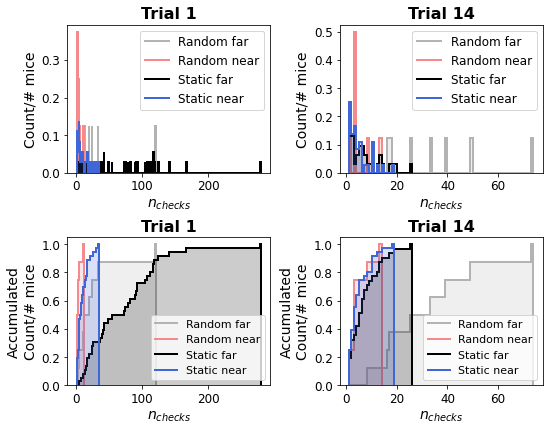

In [8]:
#import sys
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt

color_black = numpy.array((0,0,0),dtype=float)
color_gray  = 0.7*numpy.ones(3,dtype=float)

def get_edges(n):
    return numpy.append( n, n[-1]+1)

fh,axh = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=False,figsize=2.0*FIGSIZE_1PANEL)


pltt.widen_axes_distance(axh,dx=0.05,dy=-0.08)

ax              = axh[0,0]
trial_idx       = 0 # trial_idx = trial - 1; -1 == last (trial == 14)
ax.set_title(f'Trial {trial_idx+1}',fontweight='bold',fontsize=16)
nchecks_far_rt  = get_edges( dist_far_rt[trial_idx].n)
nchecks_near_rt = get_edges(dist_near_rt[trial_idx].n)
nchecks_far_ft  = get_edges( dist_far_ft[trial_idx].n)
nchecks_near_ft = get_edges(dist_near_ft[trial_idx].n)
pltt.plot_stairs_with_edge(ax, dist_far_ft[trial_idx].P,edges=nchecks_far_ft ,label='Random far' ,linewidth=2,fill=True,show_edges=True,color=color_gray     ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,dist_near_ft[trial_idx].P,edges=nchecks_near_ft,label='Random near',linewidth=2,fill=True,show_edges=True,color=color_lightred ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax, dist_far_rt[trial_idx].P,edges=nchecks_far_rt ,label='Static far' ,linewidth=2,fill=True,show_edges=True,color=color_black    ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,dist_near_rt[trial_idx].P,edges=nchecks_near_rt,label='Static near',linewidth=2,fill=True,show_edges=True,color=color_lightblue,facealpha=0.2)
ax.set_xlabel('$n_{checks}$')
ax.set_ylabel('Count/N_{mice}, P(n_{checks})')
ax.legend()

ax              = axh[0,1]
trial_idx       = 13 # trial_idx = trial - 1; -1 == last (trial == 14)
ax.set_title(f'Trial {trial_idx+1}',fontweight='bold',fontsize=16)
nchecks_far_rt  = get_edges( dist_far_rt[trial_idx].n)
nchecks_near_rt = get_edges(dist_near_rt[trial_idx].n)
nchecks_far_ft  = get_edges( dist_far_ft[trial_idx].n)
nchecks_near_ft = get_edges(dist_near_ft[trial_idx].n)
pltt.plot_stairs_with_edge(ax, dist_far_ft[trial_idx].P,edges=nchecks_far_ft ,label='Random far' ,linewidth=2,fill=True,show_edges=True,color=color_gray     ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,dist_near_ft[trial_idx].P,edges=nchecks_near_ft,label='Random near',linewidth=2,fill=True,show_edges=True,color=color_lightred ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax, dist_far_rt[trial_idx].P,edges=nchecks_far_rt ,label='Static far' ,linewidth=2,fill=True,show_edges=True,color=color_black    ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,dist_near_rt[trial_idx].P,edges=nchecks_near_rt,label='Static near',linewidth=2,fill=True,show_edges=True,color=color_lightblue,facealpha=0.2)
ax.set_xlabel('$n_{checks}$')
ax.set_ylabel('Count/N_{mice}, P(n_{checks})')
ax.legend()

ax              = axh[1,0]
trial_idx       = 0 # trial_idx = trial - 1; -1 == last (trial == 14)
ax.set_title(f'Trial {trial_idx+1}',fontweight='bold',fontsize=16)
nchecks_far_rt  = get_edges( cdist_far_rt[trial_idx].n)
nchecks_near_rt = get_edges(cdist_near_rt[trial_idx].n)
nchecks_far_ft  = get_edges( cdist_far_ft[trial_idx].n)
nchecks_near_ft = get_edges(cdist_near_ft[trial_idx].n)
pltt.plot_stairs_with_edge(ax, cdist_far_ft[trial_idx].C,edges=nchecks_far_ft ,label='Random far' ,linewidth=2,fill=True,show_edges=True,color=color_gray     ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,cdist_near_ft[trial_idx].C,edges=nchecks_near_ft,label='Random near',linewidth=2,fill=True,show_edges=True,color=color_lightred ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax, cdist_far_rt[trial_idx].C,edges=nchecks_far_rt ,label='Static far' ,linewidth=2,fill=True,show_edges=True,color=color_black    ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,cdist_near_rt[trial_idx].C,edges=nchecks_near_rt,label='Static near',linewidth=2,fill=True,show_edges=True,color=color_lightblue,facealpha=0.2)
ax.set_xlabel('$n_{checks}$')
ax.set_ylabel('Accumulated\nCount/N_{mice}')
ax.legend(fontsize=11,loc='lower right',bbox_to_anchor=((1,0)))


ax              = axh[1,1]
trial_idx       = 13 # trial_idx = trial - 1; -1 == last (trial == 14)
ax.set_title(f'Trial {trial_idx+1}',fontweight='bold',fontsize=16)
nchecks_far_rt  = get_edges( cdist_far_rt[trial_idx].n)
nchecks_near_rt = get_edges(cdist_near_rt[trial_idx].n)
nchecks_far_ft  = get_edges( cdist_far_ft[trial_idx].n)
nchecks_near_ft = get_edges(cdist_near_ft[trial_idx].n)
pltt.plot_stairs_with_edge(ax, cdist_far_ft[trial_idx].C,edges=nchecks_far_ft ,label='Random far' ,linewidth=2,fill=True,show_edges=True,color=color_gray     ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,cdist_near_ft[trial_idx].C,edges=nchecks_near_ft,label='Random near',linewidth=2,fill=True,show_edges=True,color=color_lightred ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax, cdist_far_rt[trial_idx].C,edges=nchecks_far_rt ,label='Static far' ,linewidth=2,fill=True,show_edges=True,color=color_black    ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,cdist_near_rt[trial_idx].C,edges=nchecks_near_rt,label='Static near',linewidth=2,fill=True,show_edges=True,color=color_lightblue,facealpha=0.2)
ax.set_xlabel('$n_{checks}$')
ax.set_ylabel('Accumulated\nCount/N_{mice}')
ax.legend(fontsize=11,loc='lower right',bbox_to_anchor=((1,0)))

if save_output_figures:
    fig_name = f'{output_dir}/dist_NUM_CHECKS_random_vs_static.png'
    plt.savefig(  fig_name,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    print('figure saved ::: ', fig_name)


plt.show()

plotting only static entrance

figure saved :::  figs/paper/uncertainty_random_vs_static/dist_NUM_CHECKS_static_only.png


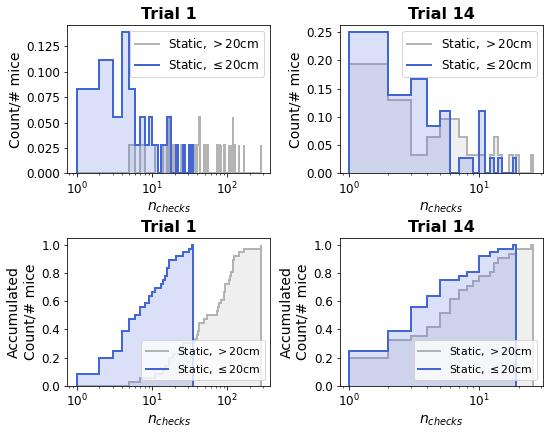

In [13]:
#import sys
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt

color_black = numpy.array((0,0,0),dtype=float)
color_gray  = 0.7*numpy.ones(3,dtype=float)

def get_edges(n):
    return numpy.append( n, n[-1]+1)

fh,axh = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=False,figsize=2.0*FIGSIZE_1PANEL)

pltt.widen_axes_distance(axh,dx=0.05,dy=-0.08)

ax              = axh[0,0]
trial_idx       = 0 # trial_idx = trial - 1; -1 == last (trial == 14)
ax.set_title(f'Trial {trial_idx+1}',fontweight='bold',fontsize=16)
nchecks_far_rt  = get_edges( dist_far_rt[trial_idx].n)
nchecks_near_rt = get_edges(dist_near_rt[trial_idx].n)
pltt.plot_stairs_with_edge(ax, dist_far_rt[trial_idx].P,edges=nchecks_far_rt ,label='Static, $>$20cm'   ,linewidth=2,fill=True,show_edges=True,color=color_gray     ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,dist_near_rt[trial_idx].P,edges=nchecks_near_rt,label='Static, $\leq$20cm',linewidth=2,fill=True,show_edges=True,color=color_lightblue,facealpha=0.2)
ax.set_xlabel('$n_{checks}$')
ax.set_ylabel('Count/N_{mice}, P(n_{checks})')
ax.legend()

ax              = axh[0,1]
trial_idx       = 13 # trial_idx = trial - 1; -1 == last (trial == 14)
ax.set_title(f'Trial {trial_idx+1}',fontweight='bold',fontsize=16)
nchecks_far_rt  = get_edges( dist_far_rt[trial_idx].n)
nchecks_near_rt = get_edges(dist_near_rt[trial_idx].n)
pltt.plot_stairs_with_edge(ax, dist_far_rt[trial_idx].P,edges=nchecks_far_rt ,label='Static, $>$20cm'   ,linewidth=2,fill=True,show_edges=True,color=color_gray     ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,dist_near_rt[trial_idx].P,edges=nchecks_near_rt,label='Static, $\leq$20cm',linewidth=2,fill=True,show_edges=True,color=color_lightblue,facealpha=0.2)
ax.set_xlabel('$n_{checks}$')
ax.set_ylabel('Count/N_{mice}, P(n_{checks})')
ax.legend()

ax              = axh[1,0]
trial_idx       = 0 # trial_idx = trial - 1; -1 == last (trial == 14)
ax.set_title(f'Trial {trial_idx+1}',fontweight='bold',fontsize=16)
nchecks_far_rt  = get_edges( cdist_far_rt[trial_idx].n)
nchecks_near_rt = get_edges(cdist_near_rt[trial_idx].n)
pltt.plot_stairs_with_edge(ax, cdist_far_rt[trial_idx].C,edges=nchecks_far_rt ,label='Static, $>$20cm'   ,linewidth=2,fill=True,show_edges=True,color=color_gray     ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,cdist_near_rt[trial_idx].C,edges=nchecks_near_rt,label='Static, $\leq$20cm',linewidth=2,fill=True,show_edges=True,color=color_lightblue,facealpha=0.2)
ax.set_xlabel('$n_{checks}$')
ax.set_ylabel('Accumulated\nCount/N_{mice}')
ax.legend(fontsize=11,loc='lower right',bbox_to_anchor=((1,0)))


ax              = axh[1,1]
trial_idx       = 13 # trial_idx = trial - 1; -1 == last (trial == 14)
ax.set_title(f'Trial {trial_idx+1}',fontweight='bold',fontsize=16)
nchecks_far_rt  = get_edges( cdist_far_rt[trial_idx].n)
nchecks_near_rt = get_edges(cdist_near_rt[trial_idx].n)
pltt.plot_stairs_with_edge(ax, cdist_far_rt[trial_idx].C,edges=nchecks_far_rt ,label='Static, $>$20cm'   ,linewidth=2,fill=True,show_edges=True,color=color_gray     ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,cdist_near_rt[trial_idx].C,edges=nchecks_near_rt,label='Static, $\leq$20cm',linewidth=2,fill=True,show_edges=True,color=color_lightblue,facealpha=0.2)
ax.set_xlabel('$n_{checks}$')
ax.set_ylabel('Accumulated\nCount/N_{mice}')
ax.legend(fontsize=11,loc='lower right',bbox_to_anchor=((1,0)))

pltt.set_axes_property(axh,xscale='log')

if save_output_figures:
    fig_name = f'{output_dir}/dist_NUM_CHECKS_static_only.png'
    plt.savefig(  fig_name,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    print('figure saved ::: ', fig_name)


plt.show()

plotting with subsampled static entrance

figure saved :::  figs/paper/uncertainty_random_vs_static/dist_NUM_CHECKS_SUBsamp_random_vs_static.png


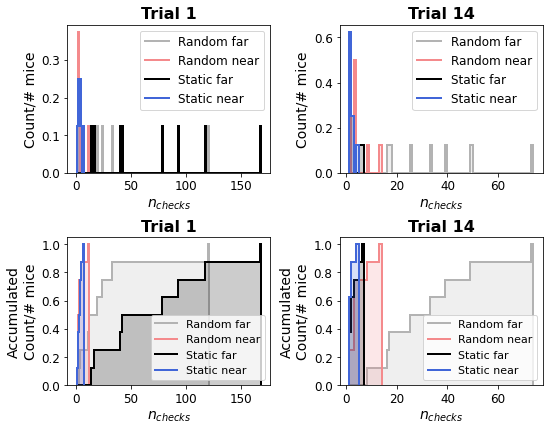

In [28]:
#import sys
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt

color_black = numpy.array((0,0,0),dtype=float)
color_gray  = 0.7*numpy.ones(3,dtype=float)

def get_edges(n):
    return numpy.append( n, n[-1]+1)

fh,axh = plt.subplots(nrows=2,ncols=2,sharex=False,sharey=False,figsize=2.0*FIGSIZE_1PANEL)


pltt.widen_axes_distance(axh,dx=0.05,dy=-0.08)

ax              = axh[0,0]
trial_idx       = 0 # trial_idx = trial - 1; -1 == last (trial == 14)
ax.set_title(f'Trial {trial_idx+1}',fontweight='bold',fontsize=16)
nchecks_far_rt  = get_edges( dist_far_sub_rt[trial_idx].n)
nchecks_near_rt = get_edges(dist_near_sub_rt[trial_idx].n)
nchecks_far_ft  = get_edges(     dist_far_ft[trial_idx].n)
nchecks_near_ft = get_edges(    dist_near_ft[trial_idx].n)
pltt.plot_stairs_with_edge(ax,     dist_far_ft[trial_idx].P,edges=nchecks_far_ft ,label='Random far' ,linewidth=2,fill=True,show_edges=True,color=color_gray     ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,    dist_near_ft[trial_idx].P,edges=nchecks_near_ft,label='Random near',linewidth=2,fill=True,show_edges=True,color=color_lightred ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax, dist_far_sub_rt[trial_idx].P,edges=nchecks_far_rt ,label='Static far' ,linewidth=2,fill=True,show_edges=True,color=color_black    ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,dist_near_sub_rt[trial_idx].P,edges=nchecks_near_rt,label='Static near',linewidth=2,fill=True,show_edges=True,color=color_lightblue,facealpha=0.2)
ax.set_xlabel('$n_{checks}$')
ax.set_ylabel('Count/N_{mice}, P(n_{checks})')
ax.legend()

ax              = axh[0,1]
trial_idx       = 13 # trial_idx = trial - 1; -1 == last (trial == 14)
ax.set_title(f'Trial {trial_idx+1}',fontweight='bold',fontsize=16)
nchecks_far_rt  = get_edges( dist_far_sub_rt[trial_idx].n)
nchecks_near_rt = get_edges(dist_near_sub_rt[trial_idx].n)
nchecks_far_ft  = get_edges(     dist_far_ft[trial_idx].n)
nchecks_near_ft = get_edges(    dist_near_ft[trial_idx].n)
pltt.plot_stairs_with_edge(ax,     dist_far_ft[trial_idx].P,edges=nchecks_far_ft ,label='Random far' ,linewidth=2,fill=True,show_edges=True,color=color_gray     ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,    dist_near_ft[trial_idx].P,edges=nchecks_near_ft,label='Random near',linewidth=2,fill=True,show_edges=True,color=color_lightred ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax, dist_far_sub_rt[trial_idx].P,edges=nchecks_far_rt ,label='Static far' ,linewidth=2,fill=True,show_edges=True,color=color_black    ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,dist_near_sub_rt[trial_idx].P,edges=nchecks_near_rt,label='Static near',linewidth=2,fill=True,show_edges=True,color=color_lightblue,facealpha=0.2)
ax.set_xlabel('$n_{checks}$')
ax.set_ylabel('Count/N_{mice}, P(n_{checks})')
ax.legend()

ax              = axh[1,0]
trial_idx       = 0 # trial_idx = trial - 1; -1 == last (trial == 14)
ax.set_title(f'Trial {trial_idx+1}',fontweight='bold',fontsize=16)
nchecks_far_rt  = get_edges( cdist_far_sub_rt[trial_idx].n)
nchecks_near_rt = get_edges(cdist_near_sub_rt[trial_idx].n)
nchecks_far_ft  = get_edges(     cdist_far_ft[trial_idx].n)
nchecks_near_ft = get_edges(    cdist_near_ft[trial_idx].n)
pltt.plot_stairs_with_edge(ax,     cdist_far_ft[trial_idx].C,edges=nchecks_far_ft ,label='Random far' ,linewidth=2,fill=True,show_edges=True,color=color_gray     ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,    cdist_near_ft[trial_idx].C,edges=nchecks_near_ft,label='Random near',linewidth=2,fill=True,show_edges=True,color=color_lightred ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax, cdist_far_sub_rt[trial_idx].C,edges=nchecks_far_rt ,label='Static far' ,linewidth=2,fill=True,show_edges=True,color=color_black    ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,cdist_near_sub_rt[trial_idx].C,edges=nchecks_near_rt,label='Static near',linewidth=2,fill=True,show_edges=True,color=color_lightblue,facealpha=0.2)
ax.set_xlabel('$n_{checks}$')
ax.set_ylabel('Accumulated\nCount/N_{mice}')
ax.legend(fontsize=11,loc='lower right',bbox_to_anchor=((1,0)))


ax              = axh[1,1]
trial_idx       = 13 # trial_idx = trial - 1; -1 == last (trial == 14)
ax.set_title(f'Trial {trial_idx+1}',fontweight='bold',fontsize=16)
nchecks_far_rt  = get_edges( cdist_far_sub_rt[trial_idx].n)
nchecks_near_rt = get_edges(cdist_near_sub_rt[trial_idx].n)
nchecks_far_ft  = get_edges(     cdist_far_ft[trial_idx].n)
nchecks_near_ft = get_edges(    cdist_near_ft[trial_idx].n)
pltt.plot_stairs_with_edge(ax,     cdist_far_ft[trial_idx].C,edges=nchecks_far_ft ,label='Random far' ,linewidth=2,fill=True,show_edges=True,color=color_gray     ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,    cdist_near_ft[trial_idx].C,edges=nchecks_near_ft,label='Random near',linewidth=2,fill=True,show_edges=True,color=color_lightred ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax, cdist_far_sub_rt[trial_idx].C,edges=nchecks_far_rt ,label='Static far' ,linewidth=2,fill=True,show_edges=True,color=color_black    ,facealpha=0.2)
pltt.plot_stairs_with_edge(ax,cdist_near_sub_rt[trial_idx].C,edges=nchecks_near_rt,label='Static near',linewidth=2,fill=True,show_edges=True,color=color_lightblue,facealpha=0.2)
ax.set_xlabel('$n_{checks}$')
ax.set_ylabel('Accumulated\nCount/N_{mice}')
ax.legend(fontsize=11,loc='lower right',bbox_to_anchor=((1,0)))

if save_output_figures:
    fig_name = f'{output_dir}/dist_NUM_CHECKS_SUBsamp_random_vs_static.png'
    plt.savefig(  fig_name,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    print('figure saved ::: ', fig_name)


plt.show()

#### Entropy of hole checks quantity

calculating entropy

In [3]:
# defining hole check detection parameters
ignore_entrance_positions = False
n_bins                    = 10
hole_horizon              = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima       = True
velocity_min_prominence   = 5.0 # cm/s

# defining the "near radius" (threshold between near target and far target)
hole_proximity_radius_threshold = 20.0 # cm

S_far_rt ,S_far_std_rt ,_  = tran.calc_number_of_checks_entropy(all_trials_for_nchecks, return_error_estimate=True, d_checks_threshold=hole_proximity_radius_threshold, less_than_threshold=False, hole_horizon=3.0, threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)
S_near_rt,S_near_std_rt,_  = tran.calc_number_of_checks_entropy(all_trials_for_nchecks, return_error_estimate=True, d_checks_threshold=hole_proximity_radius_threshold, less_than_threshold=True , hole_horizon=3.0, threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)

S_far_sub_rt ,S_far_std_sub_rt ,_  = tran.calc_number_of_checks_entropy(all_trials_rt, return_error_estimate=True, d_checks_threshold=hole_proximity_radius_threshold, less_than_threshold=False, hole_horizon=3.0, threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)
S_near_sub_rt,S_near_std_sub_rt,_  = tran.calc_number_of_checks_entropy(all_trials_rt, return_error_estimate=True, d_checks_threshold=hole_proximity_radius_threshold, less_than_threshold=True , hole_horizon=3.0, threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)

S_far_ft ,S_far_std_ft ,_  = tran.calc_number_of_checks_entropy(all_trials_ft, return_error_estimate=True, d_checks_threshold=hole_proximity_radius_threshold, less_than_threshold=False, hole_horizon=3.0, threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)
S_near_ft,S_near_std_ft,_  = tran.calc_number_of_checks_entropy(all_trials_ft, return_error_estimate=True, d_checks_threshold=hole_proximity_radius_threshold, less_than_threshold=True , hole_horizon=3.0, threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)


plotting random vs static entropy

figure saved :::  figs/paper/uncertainty_random_vs_static/entropy_NUM_CHECKS_random_vs_static.png


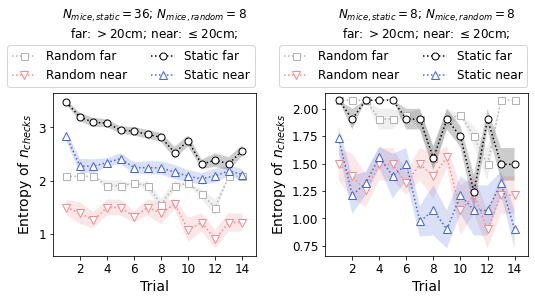

In [27]:
color_black = numpy.array((0,0,0),dtype=float)
color_gray  = 0.7*numpy.ones(3,dtype=float)


ntrial_x    = numpy.arange(14)+1

fh,axh = plt.subplots(nrows=1,ncols=2,figsize=(8,3))

pltt.widen_axes_distance(axh,dx=0.05)

ax=axh[0]
ax.set_title('$N_{mice,static}={%d}$; $N_{mice,random}={%d}$\nfar: $>%d$cm; near: $\leq%d$cm;'%(len(all_trials_for_nchecks[0]),len(all_trials_ft[0]),hole_proximity_radius_threshold,hole_proximity_radius_threshold),y=1.3)
pltt.plot_errorfill(ntrial_x,S_far_ft ,[S_far_std_ft ,S_far_std_ft ],fmt=':s',label='Random far' ,markerfacecolor='w',color=color_gray     ,ax=ax,markersize=7,alpha_fill=0.2)
pltt.plot_errorfill(ntrial_x,S_near_ft,[S_near_std_ft,S_near_std_ft],fmt=':v',label='Random near',markerfacecolor='w',color=color_lightred ,ax=ax,markersize=8,alpha_fill=0.2)
pltt.plot_errorfill(ntrial_x,S_far_rt ,[S_far_std_rt ,S_far_std_rt ],fmt=':o',label='Static far' ,markerfacecolor='w',color=color_black    ,ax=ax,markersize=7,alpha_fill=0.2)
pltt.plot_errorfill(ntrial_x,S_near_rt,[S_near_std_rt,S_near_std_rt],fmt=':^',label='Static near',markerfacecolor='w',color=color_lightblue,ax=ax,markersize=8,alpha_fill=0.2)
ax.set_xlim(0,ntrial_x[-1]+1)
ax.set_xticks(ntrial_x[1::2])
ax.set_xlabel('Trial',fontsize=14)
ax.set_ylabel('Entropy of $P(n_{checks})$',fontsize=14)
ax.legend(ncols=2,loc='lower right', bbox_to_anchor=(1.025,1))


ax=axh[1]
ax.set_title('$N_{mice,static}={%d}$; $N_{mice,random}={%d}$\nfar: $>%d$cm; near: $\leq%d$cm;'%(len(all_trials_rt[0]),len(all_trials_ft[0]),hole_proximity_radius_threshold,hole_proximity_radius_threshold),y=1.3)
pltt.plot_errorfill(ntrial_x,S_far_ft     ,[S_far_std_ft     ,S_far_std_ft     ],fmt=':s',label='Random far' ,markerfacecolor='w',color=color_gray     ,ax=ax,markersize=7,alpha_fill=0.2)
pltt.plot_errorfill(ntrial_x,S_near_ft    ,[S_near_std_ft    ,S_near_std_ft    ],fmt=':v',label='Random near',markerfacecolor='w',color=color_lightred ,ax=ax,markersize=8,alpha_fill=0.2)
pltt.plot_errorfill(ntrial_x,S_far_sub_rt ,[S_far_std_sub_rt ,S_far_std_sub_rt ],fmt=':o',label='Static far' ,markerfacecolor='w',color=color_black    ,ax=ax,markersize=7,alpha_fill=0.2)
pltt.plot_errorfill(ntrial_x,S_near_sub_rt,[S_near_std_sub_rt,S_near_std_sub_rt],fmt=':^',label='Static near',markerfacecolor='w',color=color_lightblue,ax=ax,markersize=8,alpha_fill=0.2)
ax.set_xlim(0,ntrial_x[-1]+1)
ax.set_xticks(ntrial_x[1::2])
ax.set_xlabel('Trial',fontsize=14)
ax.set_ylabel('Entropy of $P(n_{checks})$',fontsize=14)
ax.legend(ncols=2,loc='lower right', bbox_to_anchor=(1.025,1))

if save_output_figures:
    fig_name = f'{output_dir}/entropy_NUM_CHECKS_random_vs_static.png'
    plt.savefig(  fig_name,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    print('figure saved ::: ', fig_name)

plt.show()

plotting only random

LinregressResult(slope=-0.07801986283349033, intercept=3.3864655819801857, rvalue=-0.9322549906885421, pvalue=1.2046426694040967e-06, stderr=0.008740790571208773, intercept_stderr=0.07442514989038036)
LinregressResult(slope=-0.03514233269003678, intercept=2.5137547120078896, rvalue=-0.7463014065888689, pvalue=0.002171838128945175, stderr=0.009047827963596244, intercept_stderr=0.07703947908225676)
figure saved :::  figs/paper/uncertainty_random_vs_static/entropy_NUM_CHECKS_static_only.png


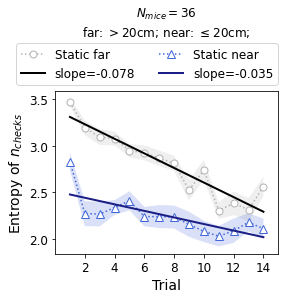

In [16]:
import sys
del sys.modules['modules.helper_func_class']
del misc
import modules.helper_func_class as misc


color_black = numpy.array((0,0,0),dtype=float)
color_gray  = 0.7*numpy.ones(3,dtype=float)

ntrial_x    = numpy.arange(14)+1




linr_far ,linr_far_func  = misc.linregress(ntrial_x, S_far_rt,return_linear_func=True)
linr_near,linr_near_func = misc.linregress(ntrial_x,S_near_rt,return_linear_func=True)

print(linr_far)
print(linr_near)




fh,axh = plt.subplots(nrows=1,ncols=1,figsize=(4,3))

pltt.widen_axes_distance(axh,dx=0.05)

ax=axh
ax.set_title('$N_{mice}={%d}$\nfar: $>%d$cm; near: $\leq%d$cm;'%(len(all_trials_for_nchecks[0]),hole_proximity_radius_threshold,hole_proximity_radius_threshold),y=1.3)
pltt.plot_errorfill(ntrial_x,S_far_rt ,[S_far_std_rt ,S_far_std_rt ],fmt=':o',label='Static far' ,markerfacecolor='w',color=color_gray     ,ax=ax,markersize=7,alpha_fill=0.2)
plt.plot(ntrial_x, linr_far_func(ntrial_x,linr_far ),'-',c=color_black   ,linewidth=2,label='slope={:.2g}'.format( linr_far.slope))
pltt.plot_errorfill(ntrial_x,S_near_rt,[S_near_std_rt,S_near_std_rt],fmt=':^',label='Static near',markerfacecolor='w',color=color_lightblue,ax=ax,markersize=8,alpha_fill=0.2)
plt.plot(ntrial_x,linr_near_func(ntrial_x,linr_near),'-',c=color_darkblue,linewidth=2,label='slope={:.2g}'.format(linr_near.slope))
ax.set_xlim(0,ntrial_x[-1]+1)
ax.set_xticks(ntrial_x[1::2])
ax.set_xlabel('Trial',fontsize=14)
ax.set_ylabel('Entropy of $P(n_{checks})$',fontsize=14)
ax.legend(ncols=2,loc='lower right', bbox_to_anchor=(1.025,1))


if save_output_figures:
    fig_name = f'{output_dir}/entropy_NUM_CHECKS_static_only.png'
    plt.savefig(  fig_name,format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')
    print('figure saved ::: ', fig_name)

plt.show()

#### plotting static entrance trials for debug

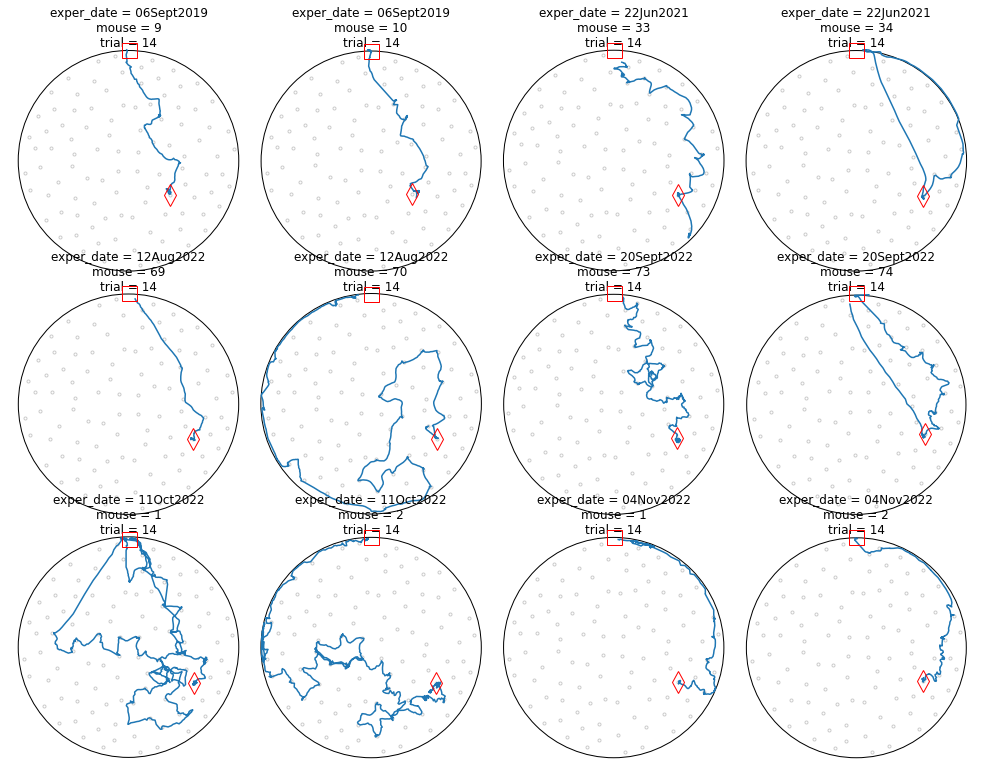

In [15]:
all_trials_for_nchecks_plot = [
    trials_for_nchecks_1,
    #trials_for_nchecks_2,
    trials_for_nchecks_3,
    trials_for_nchecks_4,
    trials_for_nchecks_5,
    trials_for_nchecks_6,
    trials_for_nchecks_7
]

def plot_arena_traj_prev(track,ax):
    ax.set_title(f'exper_date = {track.exper_date}\nmouse = {track.mouse_number}\ntrial = {track.trial}')
    pltt.plot_arena_sketch(track,ax=ax)
    pltt.plot_mouse_trajectory(ax,track)

fig,ax = plt.subplots(nrows=3,ncols=4,figsize=(20,20))
n_trial = 13
n = 0
for i,all_trials in enumerate(all_trials_for_nchecks_plot):
    m = numpy.floor(i/2).astype(int)
    for j in range(2):
        #print(m,',',n+j)
        plot_arena_traj_prev(all_trials[n_trial][j],ax[m,n+j]) # trial n_trial
        #plot_arena_traj_prev(all_trials[n_trial][1],ax[m,n+j]) # trial n_trial
    n = (n+2) if ((i%2) == 0) else 0
pltt.tight_arena_panels(ax,set_axis_off=True,adjust_title_position=True)


plt.show()